1. Perform an exploratory data analysis

    - What are the abnormalities in the data?
    - Are there any interesting, perhaps unexpected relationships to be found?


2. Create a model for predicting the cancer_type
    
    - Select an appropriate model and keep its complexity reasonable (number of used features, etc.)
    
    - I would like you to send me a submission.csv for the cases in test_data.csv at least on hour before the interview that includes the prediction of the cancer_type of your model. 
    The cases should be in the same order as in the test_data.csv and should only contain the label of the predicted cancer_type. See the sample_submission.csv for format clarification.
    
    

3. Build a regression model for predicting radius_2 based on perimeter_1
    
    - the model should be able to quantify its prediction reliability, e.g. density estimates, etc. (please do not just use the outputted R^2 or confidence interval estimates of typical linear regression packages fitting results)
    
    - prepare a visualization that illustrates possible prediction uncertainties


In [412]:
import time

# data processing library
import numpy as np
import pandas as pd
from functools import reduce
import collections

# calculating cross entropy
from math import log2

# compare distribution of the two columns using two-sample Kolmogorov-Smirnov test
from scipy.stats import ks_2samp

# data visualization library  
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

# feature engineering library
from feature_engine.outlier_removers import Winsorizer

# machine learning library
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

from sklearn import model_selection
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import preprocessing
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

# gradient boosting machine 
import lightgbm as lgbm

# feature analysis
import shap

# oversampling imbalanced datasets
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


# Perform an exploratory data analysis

- What are the abnormalities in the data?

- Are there any interesting, perhaps unexpected relationships to be found?
    


## Data processing


In [266]:
train_file = 'train_data.csv'
test_file = 'test_data.csv'
sample_submission_file = 'sample_submission.csv'


In [267]:
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)
df_sample_submission = pd.read_csv(sample_submission_file)


In [268]:
df_train.head()


,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.3070874472,82.366936,44,2006-06-03,2005-10-23,0
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.8551305385,103.078286,59,2004-02-22,2007-08-20,1
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.0971528265,143.367792,37,2006-01-06,2004-08-07,0
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.4992370844,65.920413,51,2003-04-14,2005-06-16,1
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.8566873539,108.380754,21,2004-06-21,2002-11-27,1


In [269]:
df_train.shape


(398, 13)

In [270]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        398 non-null    float64
 1   texture_0       398 non-null    float64
 2   perimeter_0     398 non-null    float64
 3   radius_1        343 non-null    float64
 4   texture_1       398 non-null    float64
 5   perimeter_1     264 non-null    float64
 6   radius_2        398 non-null    float64
 7   texture_2       398 non-null    object 
 8   perimeter_2     398 non-null    float64
 9   age             398 non-null    int64  
 10  treatment_date  398 non-null    object 
 11  diagnose_date   398 non-null    object 
 12  cancer_type     398 non-null    int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 40.5+ KB


The possible cancer types might be malignant and benign.


In [271]:
df_test.shape


(171, 12)

In [272]:
df_test.head()


,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date
0,12.567724,13.561447,77.106898,10.773643,45.494416,NaN,12.526989,15.7063580493,123.583682,31,2008-11-19,2003-04-22
1,11.195949,19.693575,81.244301,15.058411,7.909249,86.766622,13.728960,21.485344712,154.164201,18,2001-08-18,2003-07-07
2,15.712720,26.114134,90.977022,13.832857,18.086143,NaN,14.758324,27.0205254475,114.023403,43,2006-11-17,2004-03-06
3,13.428698,26.649458,76.456016,14.837875,6.122950,89.609565,16.279206,29.1837924649,199.756098,57,2001-01-10,2006-02-24
4,179.763472,14.175435,51.125047,NaN,21.116416,52.041704,9.191477,13.5857306814,74.879232,26,2008-07-12,2004-06-21


In [273]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        171 non-null    float64
 1   texture_0       171 non-null    float64
 2   perimeter_0     171 non-null    float64
 3   radius_1        146 non-null    float64
 4   texture_1       171 non-null    float64
 5   perimeter_1     105 non-null    float64
 6   radius_2        171 non-null    float64
 7   texture_2       171 non-null    object 
 8   perimeter_2     171 non-null    float64
 9   age             171 non-null    int64  
 10  treatment_date  171 non-null    object 
 11  diagnose_date   171 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 16.2+ KB


In [274]:
df_sample_submission.shape


(171, 1)

In [275]:
df_sample_submission.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cancer_type  171 non-null    int64
dtypes: int64(1)
memory usage: 1.5 KB


In [276]:
df_sample_submission.head()


,cancer_type
0,1
1,1
2,1
3,0
4,1


### Convert treatment_date, diagnose_date into datetime


In [277]:
df_train.columns


Index(['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1',
       'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age',
       'treatment_date', 'diagnose_date', 'cancer_type'],
      dtype='object')

In [278]:
df_train['treatment_date'] = pd.to_datetime(df_train['treatment_date'], format="%Y-%m-%d")
df_train['treatment_date'].describe()


count                     398
unique                    371
top       2003-04-27 00:00:00
freq                        3
first     2000-01-19 00:00:00
last      2008-11-26 00:00:00
Name: treatment_date, dtype: object

In [279]:
df_test['treatment_date'] = pd.to_datetime(df_test['treatment_date'], format="%Y-%m-%d")
df_test['treatment_date'].describe()


count                     171
unique                    160
top       2005-10-12 00:00:00
freq                        3
first     2000-01-09 00:00:00
last      2008-11-19 00:00:00
Name: treatment_date, dtype: object

In [280]:
df_train['diagnose_date'] = pd.to_datetime(df_train['diagnose_date'])
df_train['diagnose_date'].describe()


count                     398
unique                    352
top       2005-04-01 00:00:00
freq                        3
first     2002-01-09 00:00:00
last      2007-11-15 00:00:00
Name: diagnose_date, dtype: object

In [281]:
df_test['diagnose_date'] = pd.to_datetime(df_test['diagnose_date'])
df_test['diagnose_date'].describe()


count                     171
unique                    165
top       2004-10-21 00:00:00
freq                        2
first     2002-01-08 00:00:00
last      2007-08-22 00:00:00
Name: diagnose_date, dtype: object

### Convert texture_2 to float


In [282]:
df_train['texture_2'].describe()


count     398
unique    383
top        xx
freq       16
Name: texture_2, dtype: object

In [283]:
df_train['texture_2'].value_counts()


xx               16
13.432127379      1
29.8078278114     1
15.0215595848     1
20.9626231639     1
                 ..
24.9592232776     1
24.1847564043     1
16.9936648032     1
18.6624805154     1
19.5171647046     1
Name: texture_2, Length: 383, dtype: int64

In [284]:
# If ‘coerce’, then invalid parsing will be set as NaN.
df_train['texture_2'] = pd.to_numeric(df_train['texture_2'], errors='coerce')


In [285]:
df_train['texture_2'].describe()


count    382.000000
mean      19.459098
std        5.802189
min       -0.966998
25%       15.456557
50%       19.436094
75%       22.944174
max       39.331864
Name: texture_2, dtype: float64

In [286]:
df_train[['texture_2']].describe()


,texture_2
count,382.000000
mean,19.459098
std,5.802189
min,-0.966998
25%,15.456557
50%,19.436094
75%,22.944174
max,39.331864


In [287]:
df_train['texture_2'].isnull().sum()


16

In [288]:
df_test['texture_2'].describe()


count     171
unique    160
top        xx
freq       12
Name: texture_2, dtype: object

In [289]:
df_test['texture_2'] = pd.to_numeric(df_test['texture_2'], errors='coerce')


In [290]:
df_test['texture_2'].isnull().sum()


12

### Add 'month'  to the dataframe


In [291]:
df_train['diagnose_month'] = df_train['diagnose_date'].dt.month
df_train['diagnose_month'] = df_train['diagnose_month'].astype(int)


In [292]:
df_test['diagnose_month'] = df_test['diagnose_date'].dt.month
df_test['diagnose_month'] = df_test['diagnose_month'].astype(int)


## Exploratory Data Analysis (EDA)


### Target


In [293]:
target_col = 'cancer_type'
dates_col = ['diagnose_date', 'treatment_date']



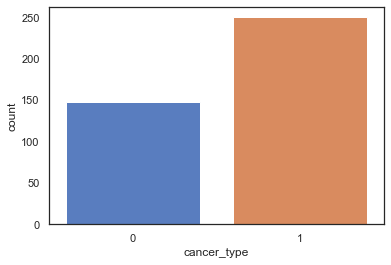

In [294]:
ax = sns.countplot(df_train[target_col], label="Count")


In [295]:
df_train[target_col].value_counts()


1    250
0    148
Name: cancer_type, dtype: int64

The possible cancer types might be malignant and benign.


### Distribution of the independent variables


#### Violin plot


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

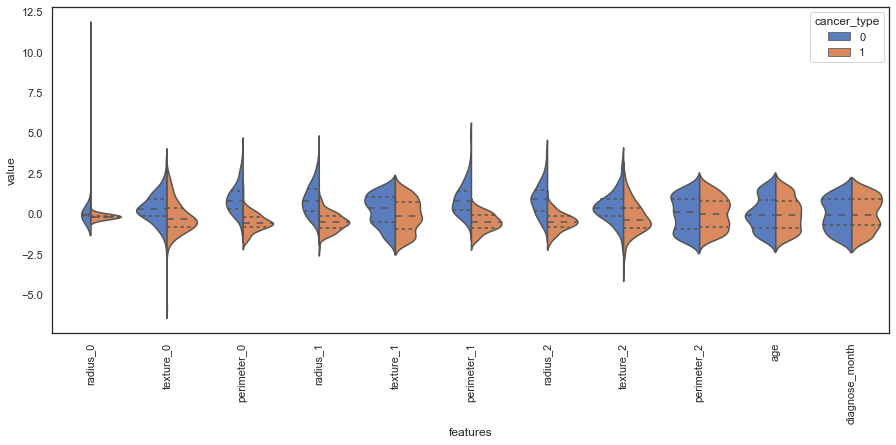

In [296]:
data_y = df_train[target_col]
data_x = df_train.drop([target_col] + dates_col, axis=1)

# standardization
data_x_stand = (data_x - data_x.mean()) / (data_x.std()) 

data_plot = pd.concat([data_y, data_x_stand], axis=1)

data_plot = pd.melt(data_plot,
                    id_vars=target_col,
                    var_name="features",
                    value_name='value',
                   )

plt.figure(figsize=(15, 6))

sns.violinplot(x="features", 
               y="value", 
               hue=target_col, 
               data=data_plot,
               split=True, 
               inner="quart",
              )

plt.xticks(rotation=90)


**Summary**

From the plot, it shows that:

- 'radius_0', 'radius_1', 'radius_2', 'texture_0', 'texture_1', 'texture_2', 
'perimeter_0', 'perimeter_1' are discriminative. 
In other words, the distributions look different for cancer types 0 and 1.

- 'permieter_2' and 'age' are not so discriminative.

- The month of the diagnose date is also the same distribution for the two types of cancer. So I will not use it as features to train machine learning models.



#### Box plot


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

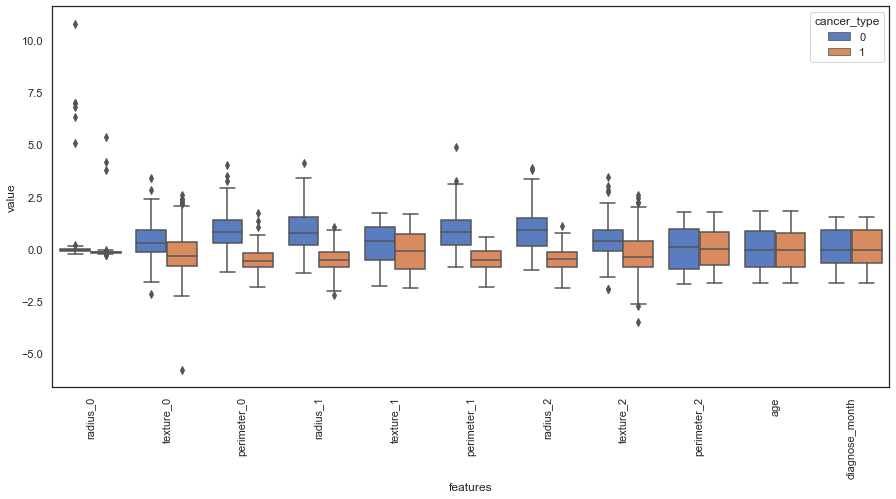

In [297]:
plt.figure(figsize=(15, 7))

sns.boxplot(x="features", 
            y="value", 
            hue=target_col, 
            data=data_plot,
           )

plt.xticks(rotation=90)



**Summary**

The box-plots show there are more outliers of 'radius_0'.

It shows that 'age' and 'diagnose_month' are not discriminative. 
So I will not use them as features to train machine learning models.


#### Swarm plot



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

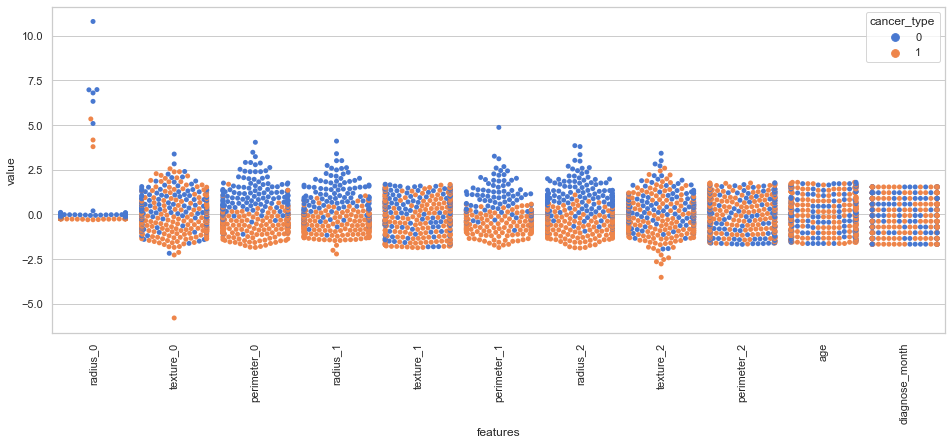

In [298]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(16, 6))

#tic = time.time()
sns.swarmplot(x="features", 
              y="value", 
              hue=target_col, 
              data=data_plot,
             )

plt.xticks(rotation=90)


**Summary**

The above plot shows that 'radius_0' is the most discriminative, i.e., most of the samples of cancer type 1 have negative 'radius_0'.

Other variables, 'perimeter_1', 'radius_2' are also discriminative. The negative value indicates that a sample has a probability that belongs to cancer type 1.


### Correlation between the variables


#### Heatmap


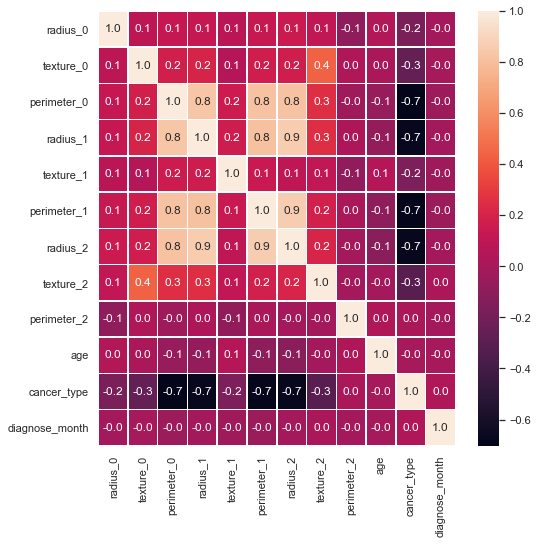

In [299]:
#correlation map
f,ax = plt.subplots(figsize=(8, 8))

sns.heatmap(df_train.drop(dates_col, axis=1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.1f',
            ax=ax,
           )


**Summary**

It shows that
- 'perimeter_0' and 'radius_1' are correlated.
- 'perimeter_1' and 'radius_2' are correlated.

'perimeter_0' shoule be correlated to 'radius_0'?
'perimeter_1' shoule be correlated to 'radius_1'?



### Plot the number of patients per month


In [300]:
def plot_cancer_per_month(cancer_type,
                          df_train, 
                          target_col,
                          month_col='diagnose_month',
                         ):
    
    couts = df_train[df_train[target_col]==cancer_type][month_col].value_counts().sort_index(ascending=False)

    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(12,5))

    ax.bar(couts.index, couts.values, color='lightblue')
    ax.plot(couts, linestyle=':', color='black')

    ax.set_title('\nNumber of patients (cancer type {}) per month\n'.format(cancer_type), 
             fontsize=14, 
             fontweight='bold',
            )
    ax.set(ylabel='\nNumber of patients (cancer type {})'.format(cancer_type))
    ax.set(xlabel='\nMonth')

    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);
    
    return


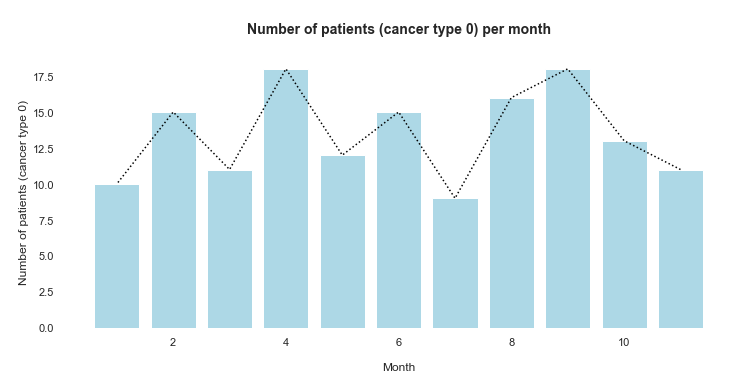

In [301]:
plot_cancer_per_month(0, df_train, target_col)


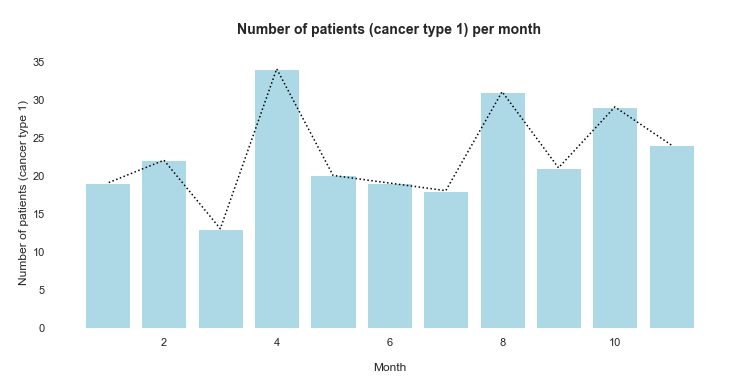

In [302]:
plot_cancer_per_month(1, df_train, target_col)


### Number of patients throughout the year


In [303]:
def plot_cancer_per_year(df_train,
                         target_col,
                         cancer_type,
                         date_col='diagnose_date',
                        ):
    
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10,6))

    df_plot = df_train[df_train[target_col]==cancer_type]
    
    df_plot[date_col].dt.year.hist(bins=24, ax=ax, color='lightblue')
    
    ax.set_title('\nPatients (cancer type = {}) through the year\n'.format(cancer_type), 
                 fontsize=14, 
                 fontweight='bold',
                )
    ax.set(xlabel='Year', 
           ylabel='Number of patients (cancer type = {})'.format(cancer_type))

    # remove all spines
    sns.despine(top=True, right=True, left=True, bottom=True);
    return


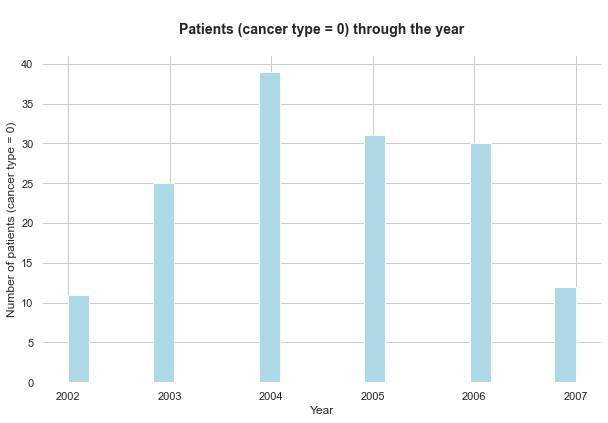

In [304]:
plot_cancer_per_year(df_train, target_col, 0)


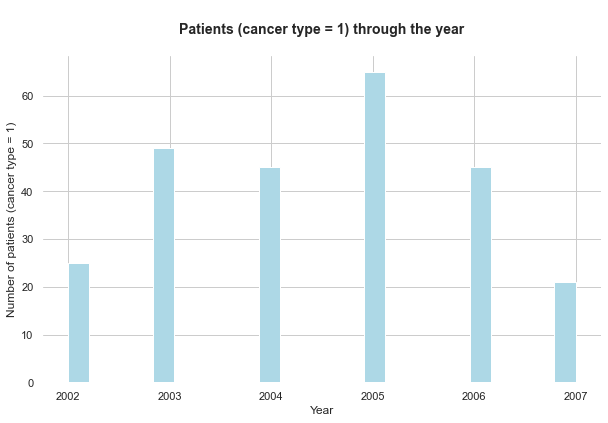

In [305]:
plot_cancer_per_year(df_train, target_col, 1)


In [306]:
df_train['diagnose_year'] = df_train['diagnose_date'].dt.year 


In [307]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    

In [308]:
df_counts = df_train.groupby(['diagnose_year', 'cancer_type']).size()

df_counts = df_counts.rename_axis(['diagnose_year', 'cancer_type']).unstack('cancer_type').reindex(columns=[0, 1])
df_counts.style.apply(highlight_max, axis=1)



cancer_type,0,1
diagnose_year,,
2002,11,25
2003,25,49
2004,39,45
2005,31,65
2006,30,45
2007,12,21


### Age


In [309]:
df_train['age'].unique()


array([44, 59, 37, 51, 21, 27, 40, 43, 50, 63, 25, 64, 18, 36, 38, 47, 54,
       62, 28, 39, 20, 60, 22, 23, 41, 34, 42, 48, 31, 26, 46, 55, 57, 35,
       56, 32, 52, 19, 49, 53, 30, 29, 61, 24, 58, 33, 45])

In [310]:
def plot_cancer_per_age(df_train,
                        target_col,
                        cancer_type,
                        age_col='age',
                        ):
    
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10,6))

    df_plot = df_train[df_train[target_col]==cancer_type]
    
    df_plot[age_col].hist(bins=24, ax=ax, color='lightblue')
    
    ax.set_title('\nPatients (cancer type = {}) through age\n'.format(cancer_type), 
                 fontsize=14, 
                 fontweight='bold',
                )
    ax.set(xlabel='Age', 
           ylabel='Number of patients (cancer type = {})'.format(cancer_type))

    # remove all spines
    sns.despine(top=True, right=True, left=True, bottom=True);
    return


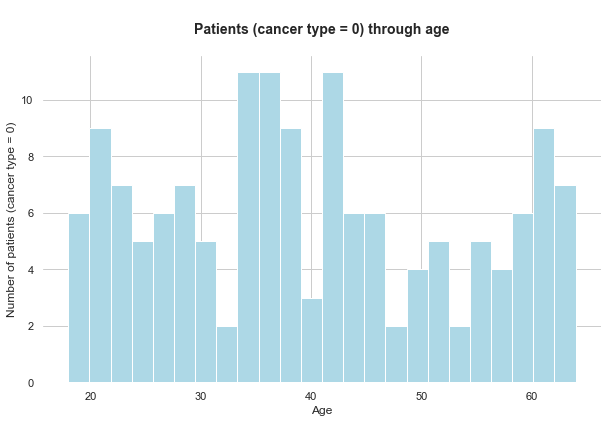

In [311]:
plot_cancer_per_age(df_train, target_col, 0)


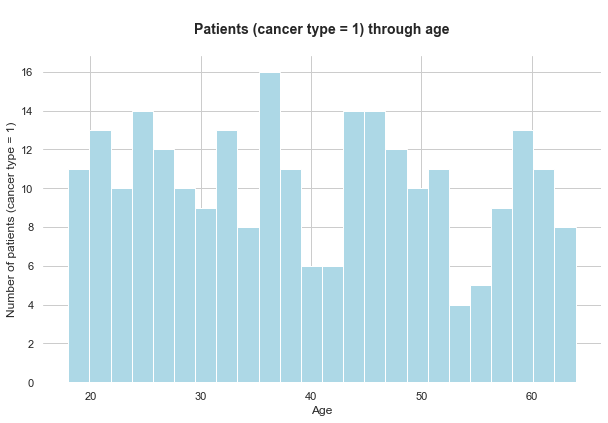

In [312]:
plot_cancer_per_age(df_train, target_col, 1)


In [313]:
def get_age_group(age):
    """
    This function turns the hours into daytime categories
    """
    if age < 20:
        return "<20"
    elif age < 30:
        return "20-30"
    elif age < 40:
        return "30-40"
    elif age < 50:
        return "40-50"
    elif age < 60:
        return "50-60"
    else:
        return ">= 60"
    

In [314]:
df_train['age_group'] = df_train['age'].apply(get_age_group)


In [315]:
def plot_pie_bar(df, col, title=''):
    f,ax=plt.subplots(1, 2, figsize=(20, 8))
    
    df[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(col)
    ax[0].set_ylabel('')
    
    sns.countplot(col, order = df[col].value_counts().index, data=df, ax=ax[1])
    ax[1].set_title(col)
    
    plt.title(title)
    plt.show()
    
    return 


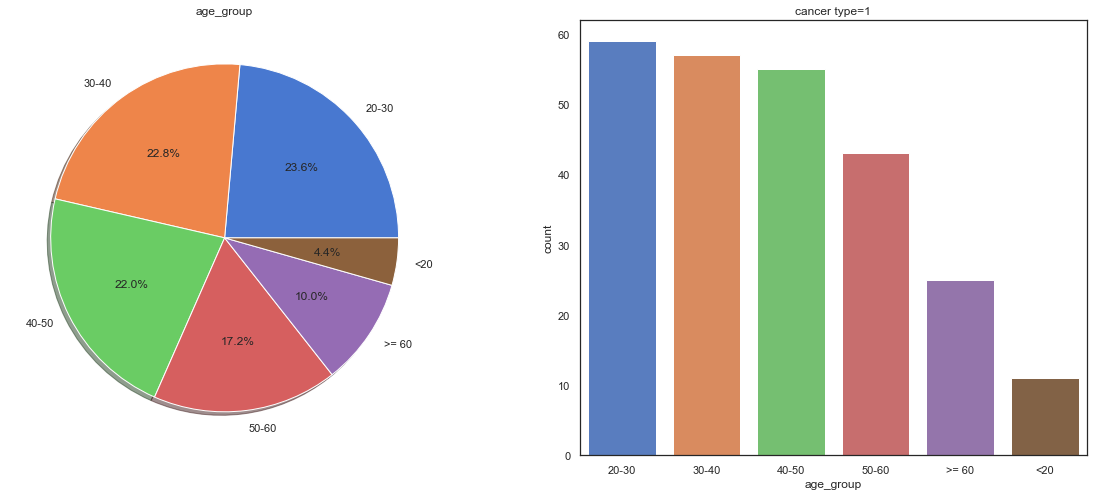

In [316]:
plot_pie_bar(df_train[df_train['cancer_type']==1], 'age_group', 'cancer type=1')


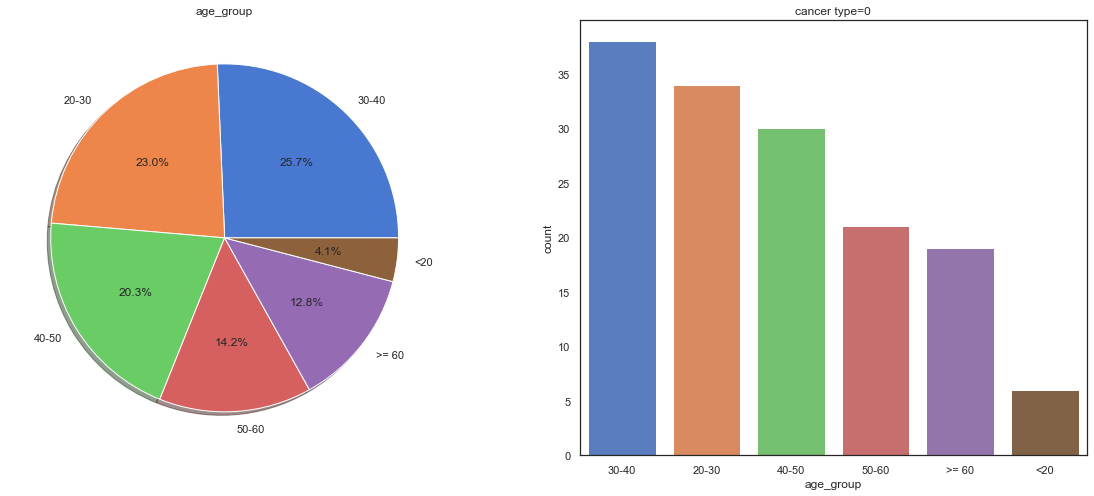

In [317]:
plot_pie_bar(df_train[df_train['cancer_type']==0], 'age_group', 'cancer type=0')


Most patients are between 20 and 50 years old


In [318]:
df_train.groupby('age_group')['cancer_type'].value_counts()


age_group  cancer_type
20-30      1              59
           0              34
30-40      1              57
           0              38
40-50      1              55
           0              30
50-60      1              43
           0              21
<20        1              11
           0               6
>= 60      1              25
           0              19
Name: cancer_type, dtype: int64

# Create a model for predicting the cancer_type



- Select an appropriate model and keep its complexity reasonable (number of used features, etc.)
    
    
- I would like you to send me a submission.csv for the cases in test_data.csv at least on hour before the interview that includes the prediction of the cancer_type of your model. The cases should be in the same order as in the test_data.csv and should only contain the label of the predicted cancer_type. See the sample_submission.csv for format clarification.
    

In order to predict the cancer type (0 or 1) of an patient.
I formulate this problem as a binary classification problem. 

Such that, given X (features, independent variables) of a patient, 
our objective is to predict Y (target, dependent variable).

The following sections conver the following steps:

1. Getting the data
1. Exploratory Data Analysis (EDA)
1. Feature Engineering
1. Model Building and Evaluation
1. Feature Analysis

Figure [Machine Learning Pipeline](#fig_machine_learning) depicts the overview of a machine learning system.

<a id='fig_machine_learning'></a>


<img src="machine_learning_pipeline.png"  width="600"/>


## Feature Engineering


### Handling missing values


In [319]:
vars_with_na = [
    var for var in df_train.columns
    if df_train[var].isnull().sum() > 0 and df_train[var].dtypes != 'O'
]

# print percentage of missing values per variable
df_train[vars_with_na].isnull().mean()


radius_1       0.138191
perimeter_1    0.336683
texture_2      0.040201
dtype: float64

In [320]:
df_train['radius_1'].describe()


count    343.000000
mean      14.123575
std        3.780636
min        5.752395
25%       11.600838
50%       13.385789
75%       16.051640
max       29.645166
Name: radius_1, dtype: float64

In [321]:
df_train['perimeter_1'].describe()


count    264.000000
mean      94.086379
std       27.314466
min       43.444930
25%       75.188880
50%       90.054613
75%      106.085670
max      227.162938
Name: perimeter_1, dtype: float64

In [322]:
df_train['texture_2'].describe()


count    382.000000
mean      19.459098
std        5.802189
min       -0.966998
25%       15.456557
50%       19.436094
75%       22.944174
max       39.331864
Name: texture_2, dtype: float64

In [323]:
df_train[vars_with_na] = df_train[vars_with_na].fillna(0)
df_test[vars_with_na] = df_test[vars_with_na].fillna(0)



**TODO**: 
impute the missing values with sklearn

https://scikit-learn.org/stable/modules/impute.html


### Handling outliers

- trimming
    - removing outliers from the dataset
    
- missing data
    - treat outliers as missing data and perform missing data imputation

- discretization
    - put outliers into lower/upper bins

- censoring
    - capping
    - top/bottom coding
    - **winsorization**

In a trimmed estimator, the extreme values are discarded; in a winsorized estimator, the extreme values are instead replaced by certain percentiles (the trimmed minimum and maximum).

**Reference**

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1431352

https://www.statisticshowto.com/winsorize/

https://www.khanacademy.org/math/ap-statistics/summarizing-quantitative-data-ap/measuring-spread-quantitative/v/calculating-interquartile-range-iqr

https://feature-engine.readthedocs.io/en/latest/outliercappers/Winsorizer.html

https://en.wikipedia.org/wiki/Interquartile_range

https://en.wikipedia.org/wiki/Quantile


#### Detect outliers
- gaussian distribution (mean and std)
- inter-quantal range proximity rule
- quantiles


In [324]:
df_train.columns


Index(['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1',
       'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age',
       'treatment_date', 'diagnose_date', 'cancer_type', 'diagnose_month',
       'diagnose_year', 'age_group'],
      dtype='object')

In [325]:
var_cols = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1', 
            'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2']


In [326]:
def plot_var(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('{} Histogram'.format(variable))

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.title('{} q-q plot'.format(variable))

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('{} Boxplot'.format(variable));

    plt.show()
    

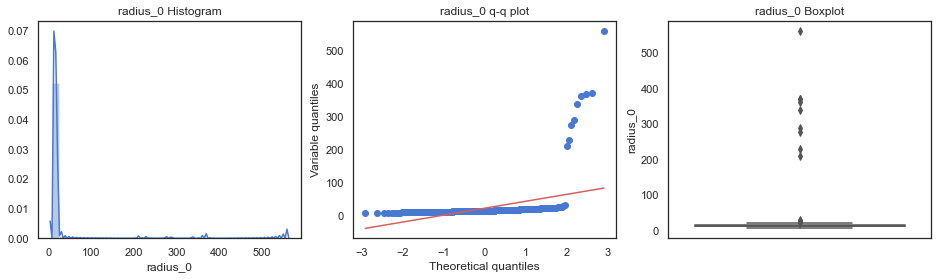

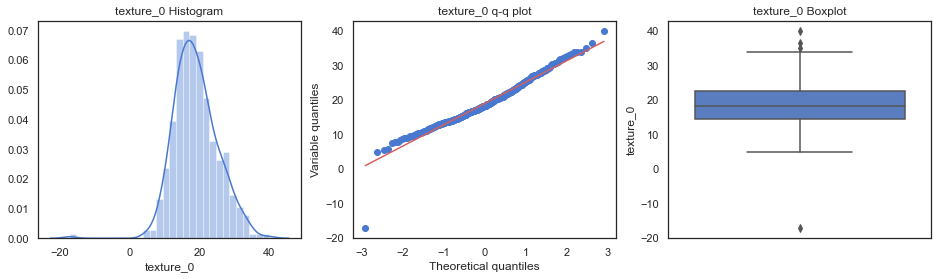

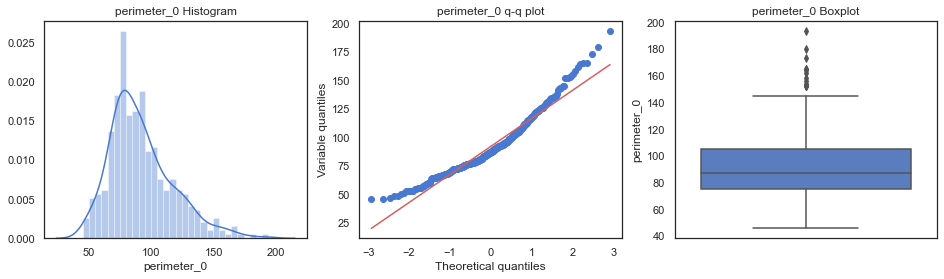

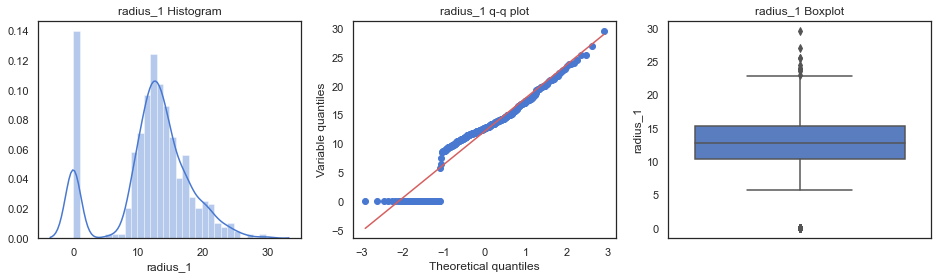

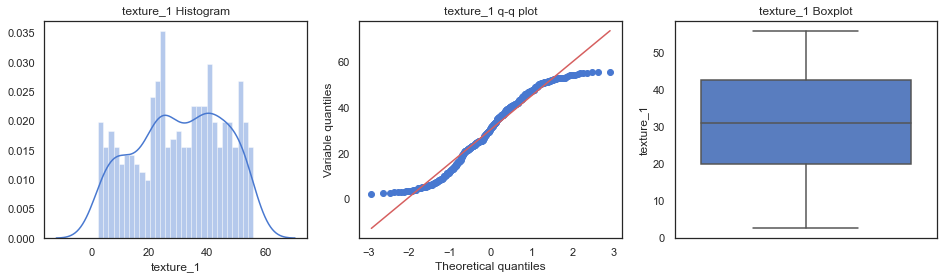

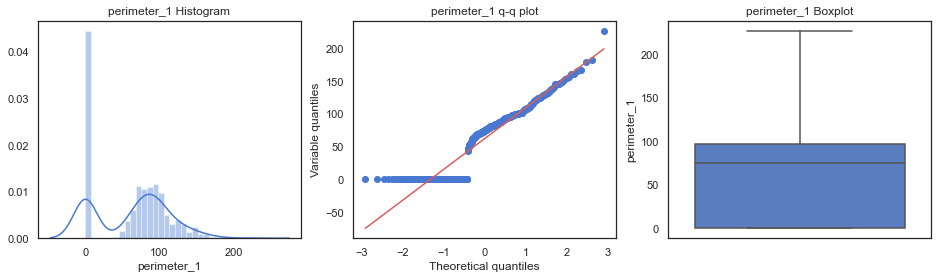

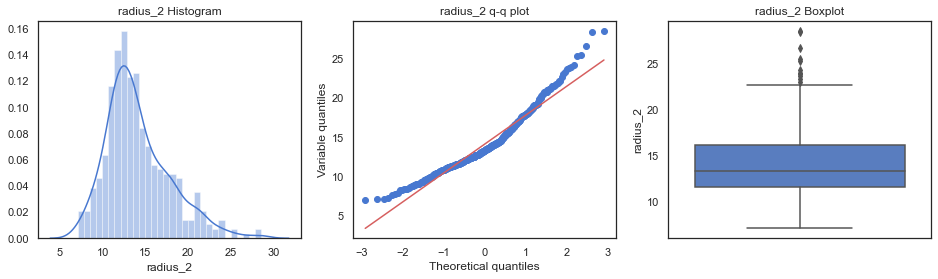

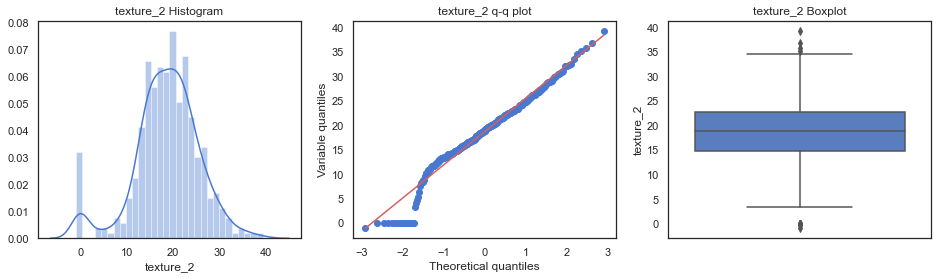

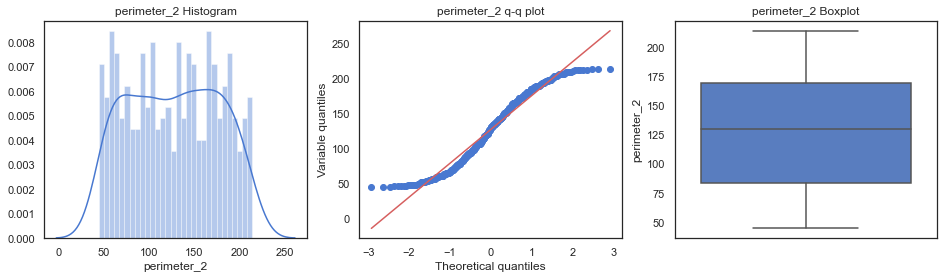

In [327]:
for col in var_cols:
    plot_var(df_train, col) 
    

In [328]:

# https://feature-engine.readthedocs.io/en/latest/outliercappers/Winsorizer.html
# https://en.wikipedia.org/wiki/Interquartile_range
# https://en.wikipedia.org/wiki/Quantile
# https://www.khanacademy.org/math/ap-statistics/summarizing-quantitative-data-ap/measuring-spread-quantitative/v/calculating-interquartile-range-iqr

"""
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

upper_limit, lower_limit = find_skewed_boundaries(df, col, 1.5)

df[col]= np.where(df[col] > upper_limit, upper_limit, 
                    np.where(df[col] < lower_limit, lower_limit, df[col]))
"""

"""
Gaussian limits:
right tail: mean + 3* std
left tail: mean - 3* std

IQR limits:
right tail: 75th quantile + 3* IQR
left tail: 25th quantile - 3* IQR

where IQR is the inter-quartile range: 75th quantile - 25th quantile.


The IQR of a set of values is calculated as the difference between the upper and lower quartiles, Q3 and Q1. 
Each quartile is a median[6] calculated as follows.

Given an even 2n or odd 2n+1 number of values
first quartile Q1 = median of the n smallest values
third quartile Q3 = median of the n largest values
The second quartile Q2 is the same as the ordinary median.
- Wikipedia
"""

var_outlier_col = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'radius_2', 'texture_2']

windsoriser = Winsorizer(distribution='skewed', # choose skewed for IQR rule boundaries or gaussian for mean and std
                         tail='both',           # cap left, right or both tails 
                         fold=1.5,
                         variables=var_outlier_col)

windsoriser.fit(df_train)

df_train_cap = windsoriser.transform(df_train)


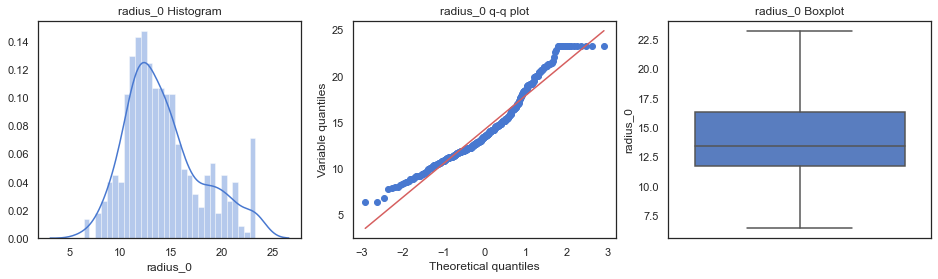

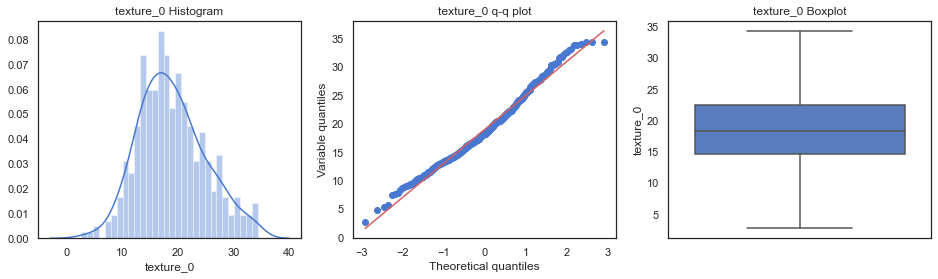

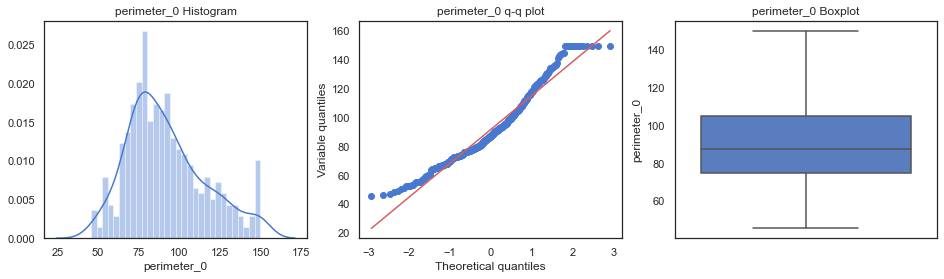

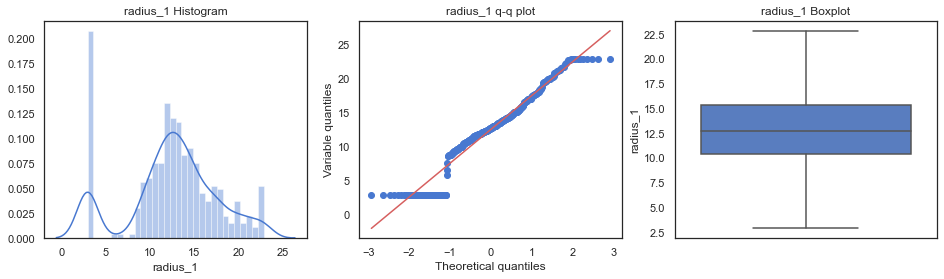

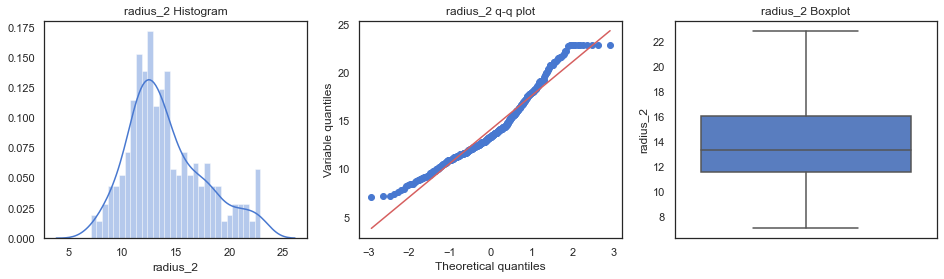

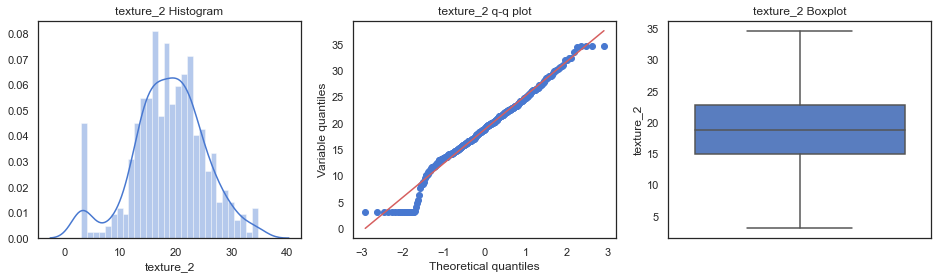

In [329]:
for col in var_outlier_col:
    plot_var(df_train_cap, col)
    

## Model Building and Evaluation


### RandomForest

The first machine learning model I use is RandomForest (RF). It is one of the most popular machine learning model. RF is a decesion tree based algorithm. A decesion tree involves the greedy selection of the best split point from the dataset at each step. Decesion trees are susceptible to high variance (overfitting) if they are not pruned.
This high variance can be harnessed and reduced by creating multiple trees with different samples of the training dataset (different views of the problem) and combining their predictions. This approach is called bootstrap aggregation or bagging for short. That's the principle of RF.


**Reference**

https://machinelearningmastery.com/implement-random-forest-scratch-python/


#### Precision, Recall, F1-score


* **Precision**

**Precision is a metric that quantifies the number of correct positive predictions made.**

It is calculated as the number of true positives divided by the total number of true positives and false positives.

$$\text{Precision} = \frac{\text{TruePositives}} {(\text{TruePositives} + \text{FalsePositives})}$$


The result is a value between 0.0 for no precision and 1.0 for full or perfect precision.


* **Recall**

**Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.**

It is calculated as the number of true positives divided by the total number of true positives and false negatives (e.g. it is the true positive rate).

$$\text{Recall} = \frac{\text{TruePositives}}{(\text{TruePositives} + \text{FalseNegatives})}$$

The result is a value between 0.0 for no recall and 1.0 for full or perfect recall.

Both the precision and the recall are focused on the positive class and are unconcerned with the true negatives.


* **F-Measure**

F-Measure provides a way to combine both precision and recall into a single measure that captures both properties.



$$ \text{F-Measure} = \frac{2 * \text{Precision} * \text{Recall}} {(\text{Precision} + \text{Recall})}$$

Like precision and recall, a poor F-Measure score is 0.0 and a best or perfect F-Measure score is 1.0.

* **Micro-average Method**

In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics. 

For example:

$$ \text{precision} = \frac{(TP1+TP2)}{(TP1+TP2+FP1+FP2)} $$

$$ \text{recall} = \frac{(TP1+TP2)}{(TP1+TP2+FN1+FN2)} $$

where TP_i means true positive of class i. 
FP_i means false positive of class i.
FN_i means false negative of class i.

* **Macro-average Method**

The macro-average method takes the average of the precision and recall of the system on different sets. 

For example:

$$ \text{precision} = \frac{(P1 + P2)}{2} $$

$$ \text{recall} = \frac{(R1 + R2)}{2} $$

P_i means the precision of class i.
R_i means the recall of class i.

Macro-average method can be used when you want to know how the system performs overall across the sets of data. You should not come up with any specific decision with this average.
On the other hand, micro-average can be a useful measure when your dataset varies in size.

* **Weighted**

Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.


**Reference**

https://www.youtube.com/watch?v=W5meQnGACGo


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/


https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/


https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/


http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html


https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52



In [330]:
feat_cols = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1', 
             'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2']

#feat_cols = ['radius_0', 'texture_0', 'radius_1', 'texture_1', 'radius_2', 'texture_2', 'perimeter_2']
#- 'perimeter_0' and 'radius_1' are correlated.
#- 'perimeter_1' and 'radius_2' are correlated.


In [331]:
X_train = df_train_cap[feat_cols]
y_train = df_train[target_col]

X_test = df_test[feat_cols]


In [332]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [333]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

model_rf.fit(X_train_sub, y_train_sub)

y_pred_rf = model_rf.predict(X_val)

report_rf = classification_report(y_val, y_pred_rf)

print(report_rf)


              precision    recall  f1-score   support

           0       0.88      0.78      0.83        46
           1       0.87      0.93      0.90        74

    accuracy                           0.88       120
   macro avg       0.88      0.86      0.86       120
weighted avg       0.88      0.88      0.87       120



In [334]:
def get_cv_scores(model, 
                  X_train, 
                  y_train, 
                  cv=3, 
                  scoring_list = ['f1_macro', 'f1_micro', 'f1_weighted'],
                  n_jobs=1,
                 ):
    cv_scores = {}
    for scoring in scoring_list:
        cv_score = cross_val_score(model, X_train, y_train, scoring=scoring, n_jobs=n_jobs, cv=cv)
        cv_scores[scoring] = cv_score
        print('{}: {}'.format(scoring, cv_score))
    
    return cv_scores


In [335]:
cv_rf = get_cv_scores(model_rf, X_train_sub, y_train_sub)


f1_macro: [0.94167816 0.91722823 0.80289855]
f1_micro: [0.94623656 0.92473118 0.81521739]
f1_weighted: [0.94606124 0.92392729 0.81575299]


#### Confusion matrix

A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. 

It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

**Reference**

https://machinelearningmastery.com/confusion-matrix-machine-learning/


In [336]:
def plot_confusion_matrix(y_test, y_preds, class_names, columns=[0, 1]):
    matrix = confusion_matrix(y_test, y_preds)

    #class_names = df_train.Did_Police_Officer_Attend_Scene_of_Accident.values
    dataframe = pd.DataFrame(matrix, index=columns, 
                             columns=columns)

    # create heatmap
    sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
    plt.show()
    

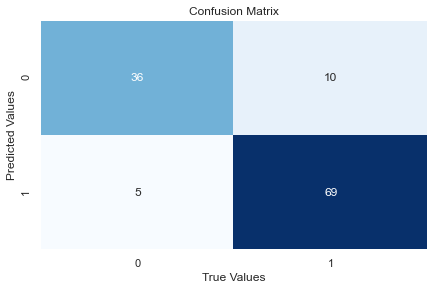

In [337]:
plot_confusion_matrix(y_val, y_pred_rf, df_train[target_col].values)


#### PR (Precision-Recall ) curve

**A PR Curve is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds.**


A model with perfect skill is depicted as a point at a coordinate of (1,1). 
A skillful model is represented by a curve that bows towards a coordinate of (1,1). 
A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. For a balanced dataset this will be 0.5.


PR curves are recommended for highly skewed domains where ROC curves may provide an excessively optimistic view of the performance. We will see ROC curves later.


**Reference**

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



In [338]:
def plot_precision_recall_curve(y_test, y_pred_prob, classifier_name):
    average_precision = average_precision_score(y_test, y_pred_prob)
    average_precision = round(average_precision, 3)
    print('Average precision-recall score: {}'.format(average_precision))

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    print('Thresholds')
    print(thresholds)
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve ({}): AP={}'.format(classifier_name, average_precision))
    
    

In [339]:
y_pred_prob_rf = model_rf.predict_proba(X_val)


Average precision-recall score: 0.952
Thresholds
[0.13 0.14 0.18 0.22 0.24 0.28 0.31 0.33 0.36 0.48 0.55 0.62 0.69 0.71
 0.72 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.86 0.88 0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]


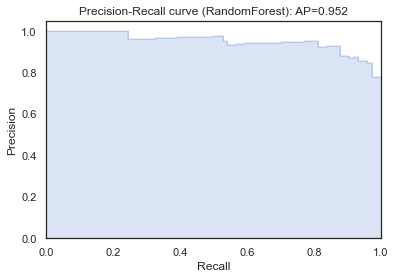

In [340]:
plot_precision_recall_curve(y_val, y_pred_prob_rf[:,-1], 'RandomForest')


#### ROC (Receiver Operating Characteristic) curve

**An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class.**

The x-axis indicates the False Positive Rate and the y-axis indicates the True Positive Rate.

The true positive rate is a fraction calculated as the total number of true positive predictions divided by the sum of the true positives and the false negatives (e.g. all examples in the positive class). 
The true positive rate is referred to as the sensitivity or the recall.

$$\text{TruePositiveRate} = \frac{\text{TruePositives}}{\text{TruePositives} + \text{False Negatives}}$$

The false positive rate is calculated as the total number of false positive predictions divided by the sum of the false positives and true negatives (e.g. all examples in the negative class).

$$\text{FalsePositiveRate} = \frac{\text{FalsePositives}}{\text{FalsePositives} + \text{TrueNegatives}}$$


The plot can be considered as the fraction of correct predictions for the positive class (y-axis) versus the fraction of errors for the negative class (x-axis).


Ideally, we want the fraction of correct positive class predictions to be 1 (top of the plot) and the fraction of incorrect negative class predictions to be 0 (left of the plot). This highlights that the best possible classifier that achieves perfect skill is the top-left of the plot (coordinate 0,1).


Perfect Skill: A point in the top left of the plot.
The threshold is applied to the cut-off point in probability between the positive and negative classes, which by default for any classifier would be set at 0.5, halfway between each outcome (0 and 1).


A trade-off exists between the **TruePositiveRate** and **FalsePositiveRate**, such that changing the threshold of classification will change the balance of predictions towards improving the **TruePositiveRate** at the expense of **FalsePositiveRate**, or the reverse case.


By evaluating the true positive and false positives for different threshold values, a curve can be constructed that stretches from the bottom left to top right and bows toward the top left. This curve is called the ROC curve.


**Reference**

https://www.kaggle.com/learn-forum/53782

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



In [341]:
def plot_roc_curve(y_test, y_pred_prob, classifier_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    roc_auc = auc(fpr, tpr)
    roc_auc = round(roc_auc, 3)
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=1, label='{} curve (AUC = {})'.format(classifier_name, roc_auc))


    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve ({})'.format(classifier_name), fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    

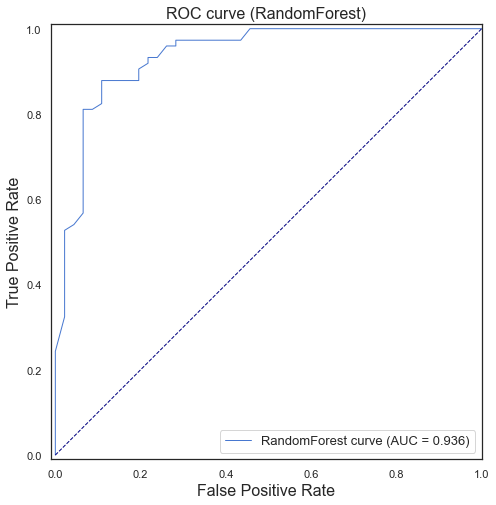

In [342]:
plot_roc_curve(y_val, y_pred_prob_rf[:,-1], 'RandomForest')


**Note**

- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.


- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.


- ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

I put the roc curve here just for reference. For this task, we should use the precision-recall curve to monitor the performance.


**Reference**


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



### LightGBM

LightGBM is a gradient boosting library which is often one of the mian algorithms used to win machine learning competitions (like Kaggle) on tabular and similar structured datasets. 

Gradient boosting is an ensemble algorithm that fits boosted decision trees by minimizing an error gradient.

Ensembles are constructed from decision tree models. 
Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. 
This is a type of ensemble machine learning model referred to as boosting.

Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. This gives the technique its name, “gradient boosting,” as the loss gradient is minimized as the model is fit, much like a neural network.



**Reference**

https://github.com/microsoft/LightGBM

https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/



In [343]:
model_lgb = lgbm.LGBMClassifier(random_state=42, n_jobs=-1)

model_lgb.fit(X_train_sub, y_train_sub)

y_pred_lgb = model_lgb.predict(X_val)

report_lgb = classification_report(y_val, y_pred_lgb)

print(report_lgb)



              precision    recall  f1-score   support

           0       0.93      0.80      0.86        46
           1       0.89      0.96      0.92        74

    accuracy                           0.90       120
   macro avg       0.91      0.88      0.89       120
weighted avg       0.90      0.90      0.90       120



In [344]:
cv_lgb = get_cv_scores(model_lgb, X_train_sub, y_train_sub)


f1_macro: [0.89357915 0.88257576 0.83461736]
f1_micro: [0.90322581 0.89247312 0.84782609]
f1_weighted: [0.90219224 0.89173998 0.84681003]


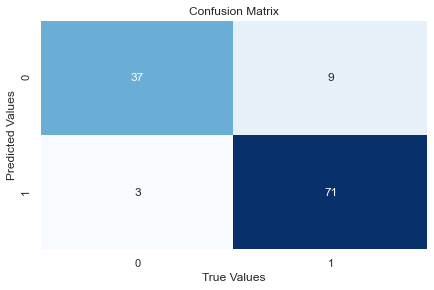

In [345]:
plot_confusion_matrix(y_val, y_pred_lgb, df_train[target_col].values)


In [346]:
y_pred_prob_lgb = model_lgb.predict_proba(X_val)


Average precision-recall score: 0.957
Thresholds
[0.00212084 0.00306989 0.0034454  0.00381143 0.0067191  0.01189515
 0.01719187 0.02252071 0.02704598 0.06323312 0.10176705 0.11695921
 0.1250298  0.1497114  0.15162034 0.16775685 0.25532026 0.26288766
 0.38596112 0.41378793 0.58388198 0.58448242 0.61057013 0.64811382
 0.67668211 0.74227648 0.8131987  0.88333363 0.89947469 0.91554929
 0.93469034 0.94492877 0.9559977  0.95603454 0.95783368 0.95808923
 0.9747884  0.98125854 0.98490987 0.98535003 0.98919865 0.99020065
 0.99108534 0.99123576 0.99138363 0.99143908 0.99169354 0.993719
 0.99418146 0.99469819 0.99473912 0.994999   0.99522872 0.99575592
 0.99631421 0.99661783 0.99705016 0.99734189 0.99734693 0.99737957
 0.99757056 0.99777368 0.99839509 0.99866785 0.99868898 0.99876081
 0.99887757 0.998897   0.99889737 0.99926533 0.99933737 0.99936625
 0.99937644 0.99941182 0.99942656 0.99943163 0.99946795 0.99947362
 0.99949136 0.99953071 0.99956453 0.99959393 0.99962555 0.99963293
 0.99963635 0.9

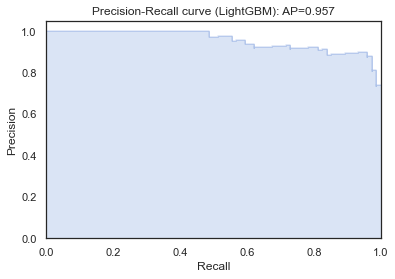

In [347]:
plot_precision_recall_curve(y_val, y_pred_prob_lgb[:,-1], 'LightGBM')


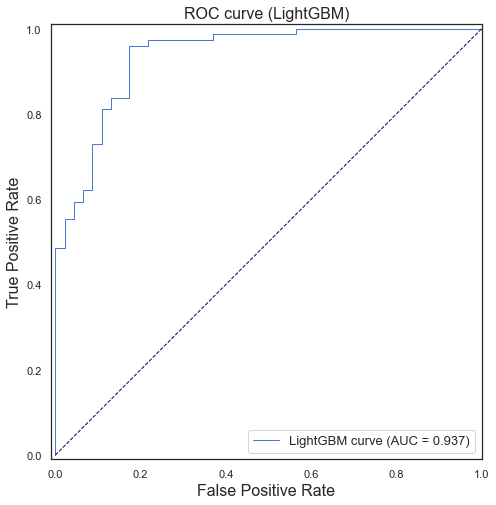

In [348]:
plot_roc_curve(y_val, y_pred_prob_lgb[:,-1], 'LightGBM')


**Summary**

The experiments show that lightGBM achieves comparable results as RandomForest.



### Hyperparameter tuning

Machine learning algorithms have hyperparameters that allow us to tailor the behavior of the algorithm to the specific dataset.

Hyperparameters are different from parameters, which are the internal coefficients or weights for a model found by the learning algorithm. 
Unlike parameters, hyperparameters are specified by the practitioner when configuring the model.


**Reference**

https://lightgbm.readthedocs.io/en/latest/Parameters.html

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
    
    

In [349]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

In [350]:
# https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}


gridParams = {
    'learning_rate': [0.005, 0.01, 0.1],
    'n_estimators': [40, 100, 500, 1000],
    'num_leaves': [6, 8, 12, 16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.2, 0.7, 0.9],
    'reg_alpha' : [0.5, 1, 1.2],
    'reg_lambda' : [0.5, 1, 1.2, 1.4],
    }

mdl = lgbm.LGBMClassifier(boosting_type= 'gbdt',
                          objective = 'binary',
                          is_unbalance = True,
                          #metric = 'binary_logloss',
                          metric = 'auc',
                          n_jobs = 1, 
                          silent = True,
                          max_depth = params['max_depth'],
                          max_bin = params['max_bin'],
                          subsample_for_bin = params['subsample_for_bin'],
                          subsample = params['subsample'],
                          subsample_freq = params['subsample_freq'],
                          min_split_gain = params['min_split_gain'],
                          min_child_weight = params['min_child_weight'],
                          min_child_samples = params['min_child_samples'],
                          scale_pos_weight = params['scale_pos_weight'],
                        )

mdl.get_params().keys()

model_lgb_randomcv = RandomizedSearchCV(mdl, 
                                        gridParams,
                                        verbose=1,
                                        cv=3,
                                        n_jobs=1,)

model_lgb_randomcv.fit(X_train_sub, y_train_sub)

report(model_lgb_randomcv.cv_results_)

print("\n Best params:\n", model_lgb_randomcv.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model with rank: 1
Mean validation score: 0.903 (std: 0.039)
Parameters: {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 42, 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 40, 'learning_rate': 0.1, 'colsample_bytree': 0.66, 'boosting_type': 'gbdt'}

Model with rank: 2
Mean validation score: 0.896 (std: 0.036)
Parameters: {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 42, 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 1000, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'boosting_type': 'gbdt'}

Model with rank: 3
Mean validation score: 0.892 (std: 0.045)
Parameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 1.2, 'random_state': 42, 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 500, 'learning_rate': 0.1, 'colsample_bytree': 0.66, 'boosting_type': 'gbdt'}


 Best params:
 {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 42, 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 40, 'l

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


In [351]:
y_pred_lgb_randomcv = model_lgb_randomcv.predict(X_val)

y_pred_prob_lgb_randomcv = model_lgb_randomcv.predict_proba(X_val)

report_lgb_randomcv = classification_report(y_val, y_pred_lgb_randomcv)

print(report_lgb)



              precision    recall  f1-score   support

           0       0.93      0.80      0.86        46
           1       0.89      0.96      0.92        74

    accuracy                           0.90       120
   macro avg       0.91      0.88      0.89       120
weighted avg       0.90      0.90      0.90       120



Average precision-recall score: 0.961
Thresholds
[0.10437204 0.12677951 0.13564765 0.14755448 0.14894983 0.15342466
 0.18967861 0.21087478 0.23727052 0.26951411 0.38665508 0.38852924
 0.39347779 0.40491254 0.40847959 0.42090493 0.43072466 0.4458547
 0.45926648 0.53995938 0.6246601  0.64881834 0.6585835  0.66348671
 0.6663273  0.66636676 0.67334134 0.71647206 0.73195238 0.8049689
 0.82561417 0.83771868 0.83933454 0.84250601 0.84693983 0.84755962
 0.84974164 0.8589042  0.86725576 0.86919197 0.87194941 0.88017156
 0.88328749 0.88389431 0.88851331 0.90011998 0.90548453 0.90864607
 0.90967637 0.91298887 0.92550022 0.92578083 0.92742401 0.9337264
 0.93674039 0.94044184 0.94697402 0.94716892 0.94783092 0.94992245
 0.95011431 0.95090944 0.95258081 0.95278888 0.9531017  0.95415519
 0.95772742 0.95899628 0.95913158 0.96059927 0.96165545 0.96217492
 0.96218417 0.96366003 0.9639135  0.96678251 0.96719504 0.96760997
 0.96799107 0.96809324 0.96868219 0.97054241 0.97094175 0.97140946
 0.97200757 0.97

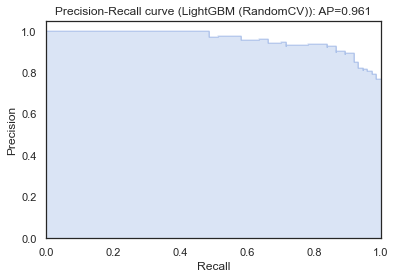

In [352]:
plot_precision_recall_curve(y_val, y_pred_prob_lgb_randomcv[:,-1], 'LightGBM (RandomCV)')


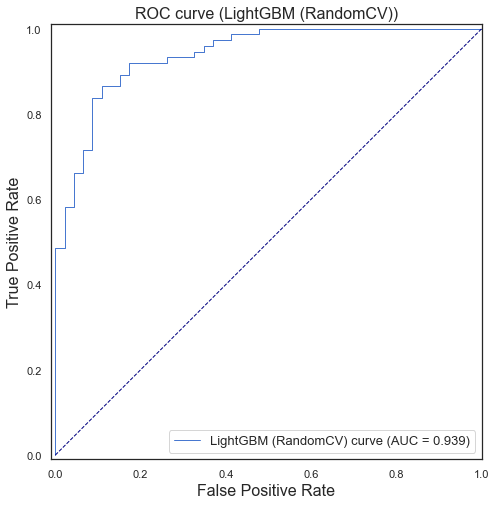

In [353]:
plot_roc_curve(y_val, y_pred_prob_lgb_randomcv[:,-1], 'LightGBM (RandomCV)')


In [354]:
model_lgb_randomcv.best_params_


{'subsample': 0.7,
 'reg_lambda': 1.2,
 'reg_alpha': 1,
 'random_state': 42,
 'objective': 'binary',
 'num_leaves': 8,
 'n_estimators': 40,
 'learning_rate': 0.1,
 'colsample_bytree': 0.66,
 'boosting_type': 'gbdt'}

In [355]:
best_params_lgb = model_lgb_randomcv.best_params_


**Summary**

It shows with hyperparameter tuning, the performance is improved.



### Stacking Ensemble

Stacking or Stacked Generalization is an ensemble machine learning algorithm.

It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

- Unlike bagging, in stacking, the models are typically different (e.g. not all decision trees) and fit on the same dataset (e.g. instead of samples of the training dataset).

- Unlike boosting, in stacking, a single model is used to learn how to best combine the predictions from the contributing models (e.g. instead of a sequence of models that correct the predictions of prior models).

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

- Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
- Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

The meta-model is trained on the predictions made by base models on out-of-sample data. That is, data not used to train the meta models is fed to the base models, predictions are made, and these predictions, along with the expected outputs, provide the input and output pairs of the training dataset used to fit the meta-model.


Stacking is appropriate when multiple different machine learning models have skill on a dataset, but have skill in different ways. Another way to say this is that the predictions made by the models or the errors in predictions made by the models are uncorrelated or have a low correlation.

Base-models are often complex and diverse. As such, it is often a good idea to use a range of models that make very different assumptions about how to solve the predictive modeling task, such as linear models, decision trees, support vector machines, neural networks, and more. Other ensemble algorithms may also be used as base-models, such as random forests.

- Base-Models: Use a diverse range of models that make different assumptions about the prediction task.


The meta-model is often simple, providing a smooth interpretation of the predictions made by the base models. As such, linear models are often used as the meta-model, such as linear regression for regression tasks (predicting a numeric value) and logistic regression for classification tasks (predicting a class label). Although this is common, it is not required.

- Regression Meta-Model: Linear Regression.
- Classification Meta-Model: Logistic Regression.


Achieving an improvement in performance depends on the complexity of the problem and whether it is sufficiently well represented by the training data and complex enough that there is more to learn by combining predictions. It is also dependent upon the choice of base models and whether they are sufficiently skillful and sufficiently uncorrelated in their predictions (or errors).

If a base-model performs as well as or better than the stacking ensemble, the base model should be used instead, given its lower complexity (e.g. it’s simpler to describe, train and maintain).


* Reference

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/




In [356]:
# get a list of models to evaluate
def get_models(best_params_lgb, n_jobs=1):
    models = dict()
    models['rf'] = RandomForestClassifier(random_state=42, n_jobs=n_jobs)
    
    #'objective': 'binary',
    #'subsample': 0.7,
    #'reg_lambda': 1,
    #'reg_alpha': 1.2,
    #'num_leaves': 12,
    #'n_estimators': 500,
    #'learning_rate': 0.1,
    #'colsample_bytree': 0.66,
    #'boosting_type': 'gbdt'
    models['lgb'] = lgbm.LGBMClassifier(random_state=42, 
                                        n_jobs=n_jobs,
                                        objective='binary',
                                        subsample=best_params_lgb['subsample'],
                                        reg_lambda=best_params_lgb['reg_lambda'],
                                        reg_alpha=best_params_lgb['reg_alpha'],
                                        num_leaves=best_params_lgb['num_leaves'],
                                        n_estimators=best_params_lgb['n_estimators'],
                                        learning_rate=best_params_lgb['learning_rate'],
                                        colsample_bytree=best_params_lgb['colsample_bytree'],
                                        boosting_type=best_params_lgb['boosting_type'],
                                       )
    models['stacking'] = get_stacking()
    return models

# get a stacking ensemble of models
def get_stacking(n_jobs=1):
    # define the base models
    level0 = list()
    level0.append(('rf', RandomForestClassifier(random_state=42, n_jobs=n_jobs)))
    level0.append(('lgb', lgbm.LGBMClassifier(random_state=42, n_jobs=n_jobs)))
    #level0.append(('gb', GradientBoostingClassifier(random_state=42)))
    #level0.append(('svm', SVC()))
    #level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
    return model
 

# evaluate a given model using cross-validation
def evaluate_model(model, X, y, n_jobs=1):
    cv = RepeatedStratifiedKFold(n_splits=4, 
                                 n_repeats=1, 
                                 random_state=42,
                                )
    scores = {}
    scoring_list = ['roc_auc', 'f1_micro', 'f1_macro', 'f1_weighted']
    
    for scoring in scoring_list:
        scores[scoring] = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score='raise')
        
    return scores




In [357]:
models = get_models(best_params_lgb)

results_auc = list()
results_f1_micro = list()
results_f1_macro = list()
results_f1_weighted = list()

names = list()

for name, model in models.items():
    scores = evaluate_model(model, X_train_sub, y_train_sub)
    
    results_auc.append(scores['roc_auc'])
    results_f1_micro.append(scores['f1_micro'])
    results_f1_macro.append(scores['f1_macro'])
    results_f1_weighted.append(scores['f1_weighted'])
    
    names.append(name)
    
    print('roc_auc >%s %.3f (%.3f)' % (name, np.mean(scores['roc_auc']), np.std(scores['roc_auc'])))
    print('f1_micro >%s %.3f (%.3f)' % (name, np.mean(scores['f1_micro']), np.std(scores['f1_micro'])))
    print('f1_macro >%s %.3f (%.3f)' % (name, np.mean(scores['f1_macro']), np.std(scores['f1_macro'])))
    print('f1_weighted >%s %.3f (%.3f)' % (name, np.mean(scores['f1_weighted']), np.std(scores['f1_weighted'])))
    

    

roc_auc >rf 0.951 (0.010)
f1_micro >rf 0.910 (0.016)
f1_macro >rf 0.901 (0.019)
f1_weighted >rf 0.909 (0.017)
roc_auc >lgb 0.954 (0.014)
f1_micro >lgb 0.906 (0.013)
f1_macro >lgb 0.896 (0.016)
f1_weighted >lgb 0.905 (0.014)
roc_auc >stacking 0.952 (0.010)
f1_micro >stacking 0.903 (0.028)
f1_macro >stacking 0.894 (0.030)
f1_weighted >stacking 0.902 (0.028)


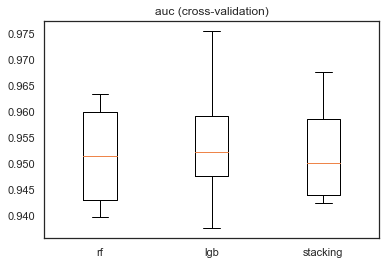

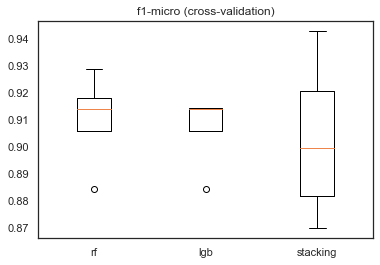

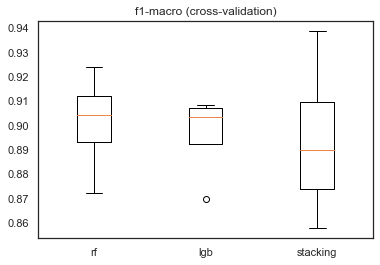

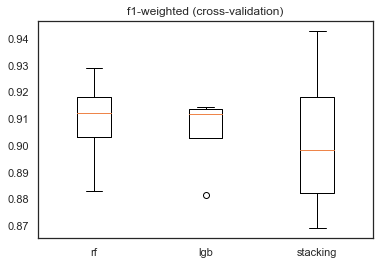

In [358]:
# plot model performance for comparison
plt.boxplot(results_auc, labels=names, showmeans=False)
plt.title('auc (cross-validation)')
plt.show()

plt.boxplot(results_f1_micro, labels=names, showmeans=False)
plt.title('f1-micro (cross-validation)')
plt.show()

plt.boxplot(results_f1_macro, labels=names, showmeans=False)
plt.title('f1-macro (cross-validation)')
plt.show()

plt.boxplot(results_f1_weighted, labels=names, showmeans=False)
plt.title('f1-weighted (cross-validation)')
plt.show()


In [359]:
model_stack = get_models(best_params_lgb)['stacking']

model_stack.fit(X_train_sub, y_train_sub)

y_pred_stack = model_stack.predict(X_val)

report_stack = classification_report(y_val, y_pred_stack)

print(report_stack)


              precision    recall  f1-score   support

           0       0.90      0.80      0.85        46
           1       0.89      0.95      0.92        74

    accuracy                           0.89       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.89      0.89       120



In [360]:
cv_stack = get_cv_scores(model_stack, X_train_sub, y_train_sub)


f1_macro: [0.90471311 0.90471311 0.83461736]
f1_micro: [0.91397849 0.91397849 0.84782609]
f1_weighted: [0.91270051 0.91270051 0.84681003]


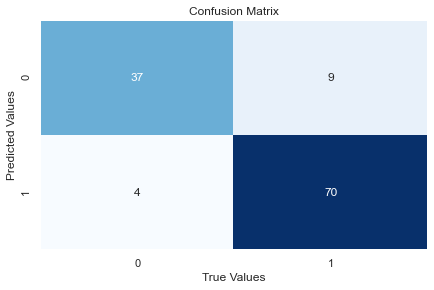

In [361]:
plot_confusion_matrix(y_val, y_pred_stack, df_train[target_col].values)



Average precision-recall score: 0.955
Thresholds
[0.10654655 0.10755843 0.10928108 0.11276081 0.13043455 0.14668315
 0.15222085 0.17039649 0.18723809 0.24675477 0.24804773 0.27953488
 0.32493542 0.3597309  0.41273096 0.42422844 0.43428532 0.55991193
 0.56063078 0.65547505 0.66681317 0.79625864 0.81390217 0.84446109
 0.84867751 0.84937007 0.85606025 0.85634722 0.88188645 0.88239541
 0.88309007 0.886749   0.89109962 0.89365718 0.89643485 0.89696715
 0.90210991 0.9027399  0.90594085 0.90597496 0.90675506 0.90717285
 0.90724922 0.91076802 0.91088174 0.91812147 0.91854211 0.91870606
 0.91900931 0.91901426 0.91902206 0.92020722 0.92090498 0.92124367
 0.92289254 0.92311293 0.92377969 0.92636889 0.92727159 0.92794304
 0.92909107 0.92986472 0.93035244 0.93059311 0.93074651 0.93111847
 0.93274237 0.93289796 0.93292141 0.93294306 0.93294608 0.93457569
 0.9346052  0.93460794 0.93468822 0.93470592 0.93474604 0.93474677
 0.93640697 0.9364222  0.93642907 0.93642977 0.93643795 0.93644334
 0.93644798 0

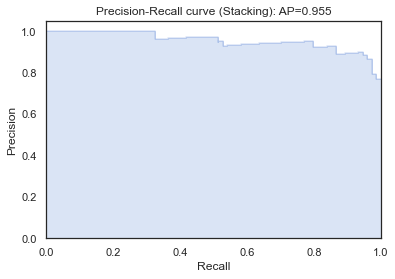

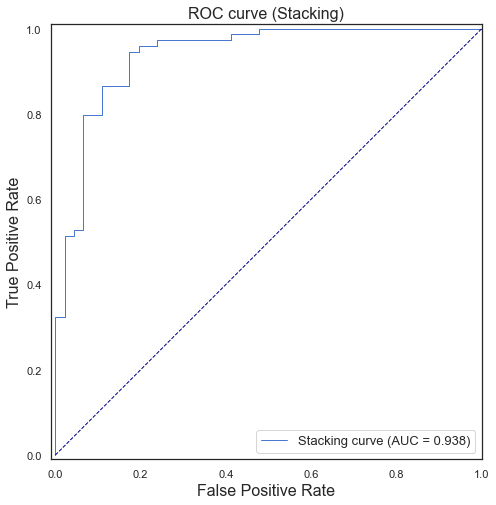

In [362]:
y_pred_prob_stack = model_stack.predict_proba(X_val)

plot_precision_recall_curve(y_val, y_pred_prob_stack[:,-1], 'Stacking')
plot_roc_curve(y_val, y_pred_prob_stack[:,-1], 'Stacking')



**Summary**

It shows stacking does not improve the performance.
But with more data and more base models, stacking might achieve better performance than other approaches.



## Feature Analysis


### SHAP feature analysis

In order to see the feature importance, I choose the SHAP (SHapley Additive exPlanations) library.


**Reference**

https://github.com/slundberg/shap


https://github.com/slundberg/shap/issues/367


https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d



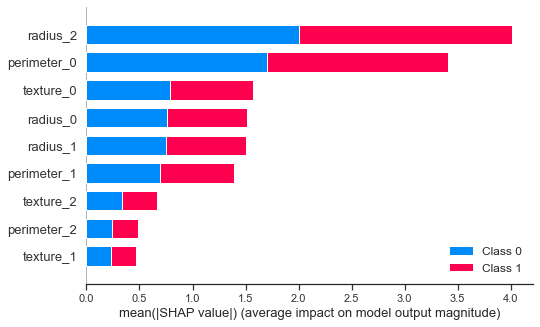

In [363]:
explainer = shap.TreeExplainer(model_lgb)

shap_values = explainer.shap_values(X_train_sub)

shap.summary_plot(shap_values, X_train_sub)


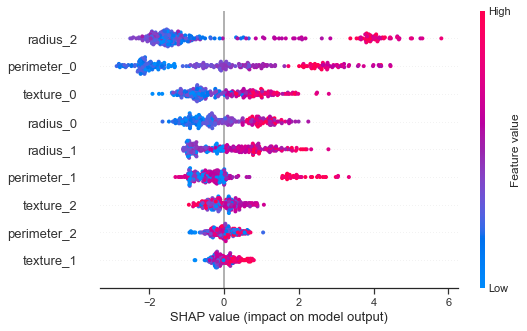

In [364]:
shap.summary_plot(shap_values[0], X_train_sub)


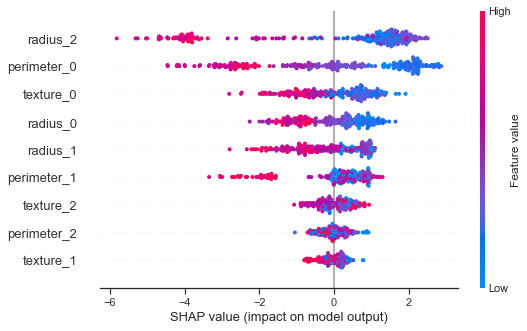

In [365]:
shap.summary_plot(shap_values[1], X_train_sub)


SHAP does not support RandomForest yet. Therefore, I plot the feature importance of the trained randomforest.
 

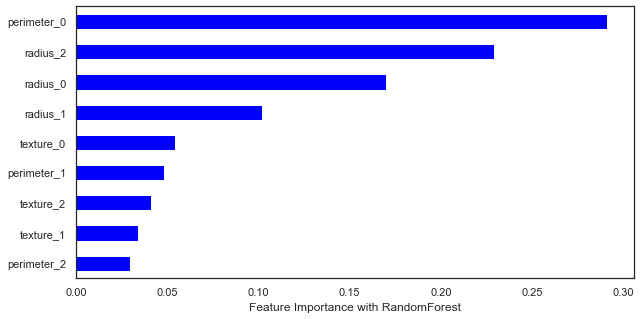

In [366]:
rf_feature_importances = pd.Series(model_rf.feature_importances_, index=X_train_sub.columns)
#feature_importances.nlargest(10).sort_values().plot(kind='barh', color='blue', figsize=(10,5))
rf_feature_importances.nlargest(20).sort_values().plot(kind='barh', color='blue', figsize=(10,5))
plt.xlabel('Feature Importance with RandomForest');



It shows that 'radius', 'perimeter_0', 'texture_0' are the most important features for the decision tree based machine learning model.


## Error Analysis (TODO)

The purpose of error analysis is to check why the error happens and how to improve the performance of the current method. Due to limited time, the error analysis is not done yet. 
The general idea is to pick some misclassified samples and investigate why the classifier made errors. Furthermore, the quality of the data needs to be checked. Sometimes, the misclassification can be caused by missing data or the noise in the data.


In [367]:
nb_error_samples = 20
X_val_error = X_val[:nb_error_samples].iloc[y_val.values[:nb_error_samples] != y_pred_lgb[:nb_error_samples]]
y_val_error = y_val[:nb_error_samples].iloc[y_val.values[:nb_error_samples] != y_pred_lgb[:nb_error_samples]]



In [368]:
pd.concat([X_val_error, y_val_error], axis=1)


,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,cancer_type
33,11.773633,21.209503,86.635025,9.724191,39.544193,0.000000,12.331317,26.760989,110.008880,0
208,14.075982,15.657610,111.415733,14.692787,44.552185,0.000000,13.272920,15.430687,60.343656,0
84,14.835990,13.908002,101.842226,15.038484,7.985041,93.438649,15.434585,22.311041,56.465762,0
94,11.095399,25.518904,64.161469,11.493383,24.732374,0.000000,11.597654,16.116447,175.218822,0


## Saving the prediction to a file


In [369]:
model_lgb_best_params = lgbm.LGBMClassifier(random_state=42, 
                                            n_jobs=1,
                                            objective='binary',
                                            subsample=best_params_lgb['subsample'],
                                            reg_lambda=best_params_lgb['reg_lambda'],
                                            reg_alpha=best_params_lgb['reg_alpha'],
                                            num_leaves=best_params_lgb['num_leaves'],
                                            n_estimators=best_params_lgb['n_estimators'],
                                            learning_rate=best_params_lgb['learning_rate'],
                                            colsample_bytree=best_params_lgb['colsample_bytree'],
                                            boosting_type=best_params_lgb['boosting_type'],
                                           )



In [370]:
model_lgb_best_params.fit(X_train, y_train)

y_pred_lgb_best_params = model_lgb_best_params.predict(X_test)


In [371]:
df_pred = pd.DataFrame()


In [372]:
df_pred['cancer_type'] = y_pred_lgb_best_params


In [373]:
df_sample_submission.shape


(171, 1)

In [374]:
df_pred.shape


(171, 1)

In [375]:
df_pred.to_csv('submission.csv', index=False)


In [376]:
df_pred = pd.read_csv('submission.csv')
df_pred.shape



(171, 1)

## System Design


This section describes how I would design and implement a long term approach.


Figure [System Design](#fig_system_design) depicts the overview of the system.

<a id='fig_system_design'></a>


<img src="system_design.png"  width="600"/>

**Fig1: System Design**

## Data Pipeline

The data would be stored in a database management system. PostgreSQL is my first choice. Because PostgreSQL isn't just relational, it's object-relational. It is one of the most popular open-source relational database in the world. It gives it some advantages over other open source SQL databases for example MySQL and SQLite. More details of PostgreSQL can be found in [1]. 


Different types of data (csv, text, image, etc) will be used for machine learning for this use case.
For this reason, I will create a big data platform.
Cloudera would be my first choie. It is a open source platform as popular distributions of Hadoop. 


Hadoop can be used to store and process structured, semi-structured, and unstructured data. This also supports a variety of data formats in real-time such as XML, JSON, and text-based flat file formats. RDBMS (Relational Database Management System) works efficiently when there is an entity-relationship flow that is defined perfectly and therefore, the database schema or structure can grow and unmanaged otherwise. i.e., an RDBMS works well with structured data. Hadoop will be a good choice in environments when there are needs for big data processing on which the data being processed does not have dependable relationships. A deep comparison between Hadoop and traditional relational database can be found in [2][3]. 


The next step is to build a backend data access API. 
The details of how to design a backend API can be found in [4].
The data access provides the functions of getting the data from the database, exporting the data to some formats of files (e.g., xls, csv), inserting and getting the data to/from the hadoop platform, calling a data API to get external data (e.g., weather, holiday, etc).
This API can be written in python, java or scala. Python is the first choice. Because the machine learning pipeline will use this API heavily. Nowadays python is the most popular language for machine learning.

An external data API will be built in order to get some external data, e.g., weather, holiday information, etc.
This API is a RESTFull (REpresentational State Transfer) API.
RESTFull has emerged as the standard architectural design for web services and web APIs.
This API uses Python and Flask which is a lightweight web application framework. 
Details of how to use Python and Flask to build a RESTFull API can be found in [5].


## Machine Learning Pipeline

Figure [Model Pipeline](#fig_model_pipeline) depicts the overview of the machine pipeline.
The machine learning pipeline contains several components.

<a id='fig_model_pipeline'></a>


<img src="model_pipeline.png"  width="500"/>

**Fig2: Machine Learning Model Pipeline**



### Ground Truth Preprocessing

In this component, data retrieved by the data API is preprocessed for machine learning. In other words, the target Y (what we want to predict) is defined in this component.



### Feature Encoding

From the raw data, the feature set X is encoded in this component. 
Data will be retrieved by pandas. Then different preprocessing and feature extraction pipelines to different subsets of features are grouped into one sklearn pipeline.
To group different data process pipelines into one pipeline, a solution would be using the sklearn ColumnTransformer as explained in [6]



### Model training

With the feature set X and target Y, a machine learning model is trained in this component.
The trained machine learning is used to predict the target of the unseen data.
Some popular machine learning, deep learning frameworks (Sklearn, XGBoost, LightGBM, TensorFlow, Keras, PyTroch) can be used to train the models.
The details of how to perform model training can be found in [7].



### Performance Monitoring

In order to select the best machine learning model, we need to monitor the performance of the models. One solution is to use Neptune [8] which can be used to track the experiments.
The details of how to monitoring a machine learning model can be found in [9][10].



### Model Deployment

Deployment is the method by which we integrate a machine learning model into an existing production environment to make practical business decisions based on data. 
It is one of the last stages in the machine learning life cycle and can be one of the most cumbersome. The details of how to deploy machine learning models can be found in [10-15].

I will use Jenkins [9] for model deployment.
Jenkins is an open-source server that can be used to automate the tasks related to building, testing, and delivering or deploying software.



## Prediction API

After a machine learning model is trained. We will need to create a web service API, such given an unseen data the API can predict the target.
The details of how to create a RESTFull API with Flask to perform machine learning can be found in [16][17].



## Frontend UI

The user can see the prediction in the web interface.
The web interface can be built with Node.js [18][19].
Using AngularJS or ReactJS for frontend development can be an optional solution.

Note AngularJS is a fully-featured framework than ReactJS, which is not really a framework but a library. With ReactJS, we write less code. ReactJS is better than AngularJS when it comes to their performance. However, AngularJS has a large support community and following.

On the other hand, Nodejs is simply a JavaScript runtime that is lightweight and fast. It is mainly created to build fast and scalable network applications.

The comparison between the frameworks can be found in [20].



## Reference

[1] SQLite vs MySQL vs PostgreSQL: A Comparison Of Relational Database Management Systems, https://www.digitalocean.com/community/tutorials/sqlite-vs-mysql-vs-postgresql-a-comparison-of-relational-database-management-systems

[2] Big Data Hadoop vs. Traditional RDBMS, https://tdan.com/big-data-hadoop-vs-traditional-rdbms/24736#

[3] HADOOP vs RDBMS, https://www.educba.com/hadoop-vs-rdbms/

[4] Why You Should Build Apps With An API Backend, https://nordicapis.com/why-you-should-build-apps-with-an-api-backend-baas/

[5] Designing a RESTful API with Python and Flask, https://blog.miguelgrinberg.com/post/designing-a-restful-api-with-python-and-flask

[6] Column Transformer with Mixed Types, https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

[7] Model Training,
https://elitedatascience.com/model-training

[8] Neptune, https://neptune.ai/

[9] Jenkins, https://www.jenkins.io/

[10] Monitoring Machine Learning Models in Production, https://christophergs.com/machine%20learning/2020/03/14/how-to-monitor-machine-learning-models/

[11] Learning the Learner: The Ultimate Way to Monitor Machine Learning, https://www.anodot.com/blog/monitoring-machine-learning/

[12] Overview of Different Approaches to Deploying Machine Learning Models in Production,
https://www.kdnuggets.com/2019/06/approaches-deploying-machine-learning-production.html

[13] How to Deploy Machine Learning Models,
https://christophergs.com/machine%20learning/2019/03/17/how-to-deploy-machine-learning-models/

[14] Machine Learning Model Deployment,
https://www.datarobot.com/wiki/machine-learning-model-deployment/

[15] Deployment of Machine learning Models Demystified (Part 1),
https://towardsdatascience.com/deployment-of-machine-learning-model-demystified-part-1-1181d91815d2

[16] Machine Learning Model with FLASK REST API, 
https://hackernoon.com/machine-learning-w22g322x


[17] Deploying a Machine Learning Model as a REST API,
https://towardsdatascience.com/deploying-a-machine-learning-model-as-a-rest-api-4a03b865c166


[18] An Introduction to Node.js for Front-End Developers,
https://speckyboy.com/node-js-for-front-end-developers/


[19] Learn Node.js,
https://frontendmasters.com/books/front-end-handbook/2018/learning/node.html


[20] AngularJS vs ReactJS vs NodeJS: Which One Is best?
https://www.markupbox.com/blog/angularjs-vs-reactjs-vs-nodejs-which-one-is-best/


[21] Using Machine Learning to Predict Value of Homes On Airbnb
https://medium.com/airbnb-engineering/using-machine-learning-to-predict-value-of-homes-on-airbnb-9272d3d4739d



# Build a regression model for predicting radius_2 based on perimeter_1

- the model should be able to quantify its prediction reliability, e.g. density estimates, etc. (please do not just use the outputted R^2 or confidence interval estimates of typical linear regression packages fitting results)


- prepare a visualization that illustrates possible prediction uncertainties



**Reference**

https://machinelearningmastery.com/linear-regression-for-machine-learning/

https://machinelearningmastery.com/simple-linear-regression-tutorial-for-machine-learning/

https://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/

https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/



## Distribution of the variables


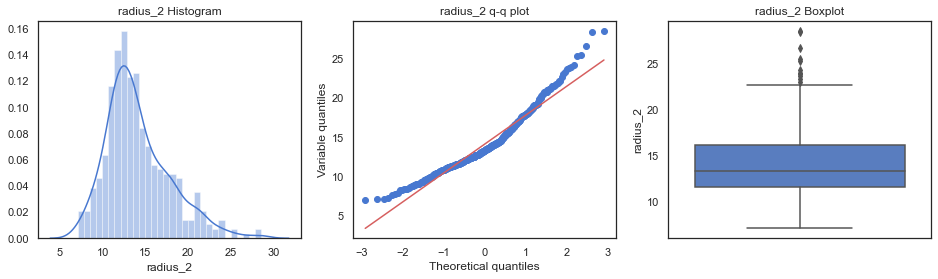

In [377]:
plot_var(df_train, 'radius_2')


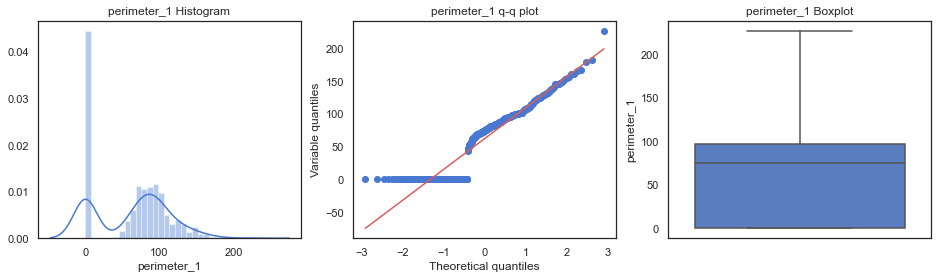

In [378]:
plot_var(df_train, 'perimeter_1')


## Correlation between the variables


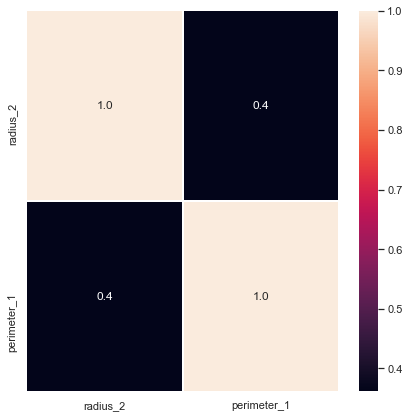

In [379]:
#correlation map
f,ax = plt.subplots(figsize=(7, 7))

sns.heatmap(df_train[['radius_2', 'perimeter_1']].corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.1f',
            ax=ax,
           )


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


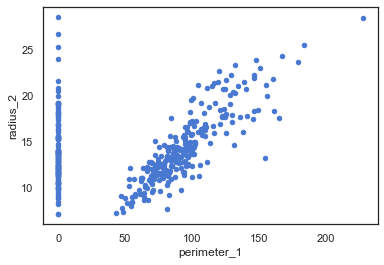

In [380]:
ax = df_train.plot.scatter(x='perimeter_1', y='radius_2')


In [381]:
len(df_train[df_train['perimeter_1']==0]['radius_2'].unique())


134

- It shows that when 'perimeter_1' equals to 0, it is not possible to predict radius

- It shows there is a linear correlation between 'perimeter_1' and 'radius_2', when 'perimeter_1' is bigger than 0




### Remove outliers

- Remove the data such that 'perimeter_1' equals to 0


In [382]:
df_train_clip = df_train.copy()

df_train_clip = df_train_clip[df_train_clip['perimeter_1'] != 0]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


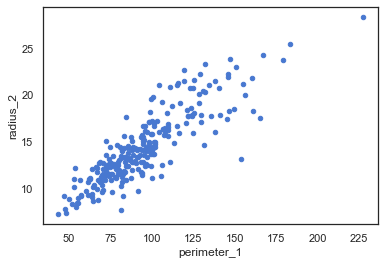

In [383]:
ax = df_train_clip.plot.scatter(x='perimeter_1', y='radius_2')


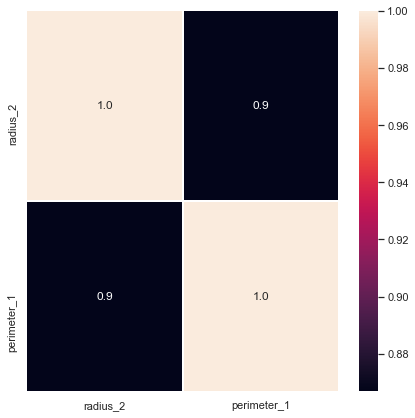

In [384]:
f,ax = plt.subplots(figsize=(7, 7))

sns.heatmap(df_train_clip[['radius_2', 'perimeter_1']].corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.1f',
            ax=ax,
           )


### Scale independent variables


In [385]:
X_train = df_train_clip[['perimeter_1']]
y_train = df_train_clip[['radius_2']]


In [386]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [387]:
scaler = preprocessing.StandardScaler().fit(X_train)


In [388]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Regression Metrics

The most common metrics for evaluating predictions on regression machine learning problems:

- R^2 ( R Squared)

- Mean Absolute Error (MAE)

- Mean Squared Error (MSE)

- Root Mean Squared Error (RMSE)

- Root Mean Squared Logarithm Error (RMSLE)



###  R^2 Metric (R Squared)

The R Squared metric provides an indication of the goodness of fit of a set of predictions to the actual values. 
In statistical literature, this measure is called the coefficient of determination.
This is a value between 0 and 1 for no-fit and perfect fit respectively.
Define $y$ as target variable, $\hat{y}$ as the prediction, then

$$\overline{y} = \frac{1}{n} (\sum_{i} (y_i))$$

$$S_{\text{tot}} = \sum_{i} (y_i - \overline{y})^2$$

$$S_{\text{res}} = \sum_{i} (y_i - \hat{y_i})^2$$

$$R^2 = 1 - \frac{S_{\text{res}}}{S_{\text{tot}}}$$

R-squared gives an estimate of the relationship between movements of a dependent variable (target) based on an independent variable's (features) movements. 
It doesn't tell whether the chosen model is good or bad, nor will it tell whether the data and predictions are biased. 

**A high or low R-square isn't necessarily good or bad, as it doesn't convey the reliability of the model, nor whether you've chosen the right regression.**

We can get a low R-squared for a good model, or a high R-square for a poorly fitted model, and vice versa.


### Mean Absolute Error (MAE)

MAE is the average of the absolute differences between predictions and actual values. 
It gives an idea of how wrong the predictions were.
The measure gives an idea of the magnitude of the error, but no idea of the direction (e.g. over or under predicting).

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y_i}|$$

### Mean Squared Error (MSE)

MSE is much like the mean absolute error in that it provides a gross idea of the magnitude of error.

Taking the square root of the mean squared error converts the units back to the original units of the output variable and can be meaningful for description and presentation. 
This is called the Root Mean Squared Error (or RMSE).

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \frac{(y_i - \hat{y_i})^2}{n}$$

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \frac{(y_i - \hat{y_i})^2}{n}}$$


### Root Mean Squared Log Error (RMSLE)

$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \frac{(\log{(y_i+1)} - \log{(\hat{y_i}+1))^2}}{n}}$$


### MAE, MSE, RMSE, and RMSLE

- MAE gives less weight to outliers, which is not sensitive to outliers.

- MSE is like a combination measurement of bias and variance of the prediction, 
i.e., MSE = Bias^2 + Variance, which is more popular than MAE.

- RMSE refers to Root MSE. It takes a root of MSE would bring the unit back to actual unit, 
easy to interpret the model accuracy.

- In RMSLE, we take the log of the predictions and actual values. 
So basically, what changes is the variance that we are measuring. 
RMSLE is usually used when we don't want to penalize huge differences in the predicted and the actual values when both predicted and true values are huge numbers.

    - If both predicted and actual values are small: RMSE and RMSLE is same.
    - If either predicted or the actual value is big: RMSE > RMSLE
    - If both predicted and actual values are big: RMSE > RMSLE (RMSLE becomes almost negligible) [10] 

- RMLSE penalizes the underestimation of the actual value more severely than it does for the overestimation.[7]


- **Reference**

[1] https://en.wikipedia.org/wiki/Dependent_and_independent_variables

[2] https://en.wikipedia.org/wiki/Coefficient_of_determination

[3] https://www.investopedia.com/terms/r/r-squared.asp

[4] https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

[5] https://www.khanacademy.org/math/ap-statistics/bivariate-data-ap/assessing-fit-least-squares-regression/v/r-squared-or-coefficient-of-determination

[6] https://statisticsbyjim.com/regression/interpret-r-squared-regression/

[7] https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

[8] https://www.quora.com/Why-we-use-Root-mean-square-error-RMSE-Mean-absolute-and-mean-absolute-percent-errors-for-forecasting-time-series-models

[9] https://www.kaggle.com/learn-forum/52081

[10] https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064



## Model training and evaluation


### MAE


In [466]:
kfold = model_selection.KFold(n_splits=4, random_state=42)
model = LinearRegression()
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)

results *= -1
print('mean_absolute_error')
print(results)
print(results.mean())
print(results.std())


mean_absolute_error
[1.35465284 1.70046415 1.1974609  1.21128146]
1.3659648374643485
0.20269328745996187


### MSE


In [467]:
kfold = model_selection.KFold(n_splits=4, random_state=42)
model = LinearRegression()
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)

results *= -1
print('mean_squared_error')
print(results)
print(results.mean())
print(results.std())


mean_squared_error
[2.4952197  4.89197592 2.63980091 2.86391203]
3.2227271394093187
0.9726522805146202


### RMSE


In [468]:
kfold = model_selection.KFold(n_splits=4, random_state=42)
model = LinearRegression()
scoring = 'neg_root_mean_squared_error'
results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)

results *= -1
print('root_mean_squared_error')
print(results)
print(results.mean())
print(results.std())


root_mean_squared_error
[1.57962644 2.21178116 1.62474641 1.69230967]
1.777115923597124
0.2541380205849948


### MSLE


In [469]:
kfold = model_selection.KFold(n_splits=4, random_state=42)
model = LinearRegression()
scoring = 'neg_mean_squared_log_error'
results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)

results *= -1
print('mean_squared_log_error')
print(results)
print(results.mean())
print(results.std())


mean_squared_log_error
[0.01182664 0.01783069 0.01015034 0.01134762]
0.012788820505576087
0.002974262747425408


In [470]:
def report_performance(y_test, y_pred):
    #print(np.ravel(y_test))
    #print(np.ravel(y_pred))
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    msle = mean_squared_log_error(y_test, y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    
    #ce = cross_entropy(np.ravel(y_test), np.ravel(y_pred))
    
    print("mae: {:.2f}".format(mae))
    print("mse: {:.2f}".format(mse))
    print("rmse: {:.2f}".format(rmse))
    print("msle: {:.2f}".format(msle))
    print("rmsle: {:.2f}".format(rmsle))
    #print("cross-entropy: {:.2f}".format(ce))
    
    return


In [471]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

report_performance(y_test, y_pred)


mae: 1.43
mse: 4.25
rmse: 2.06
msle: 0.02
rmsle: 0.13


In [472]:
df_test = X_test
df_test['radius_2_gt'] = y_test.values.ravel()
df_test['radius_2_pred'] = y_pred.ravel()



In [473]:
df_test.head()


,perimeter_1,radius_2_gt,radius_2_pred
111,94.113057,11.411559,14.282127
296,86.955049,13.258687,13.424718
137,95.001245,15.120483,14.388517
377,74.029302,11.343637,11.876432
171,115.977687,21.311523,16.901141


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


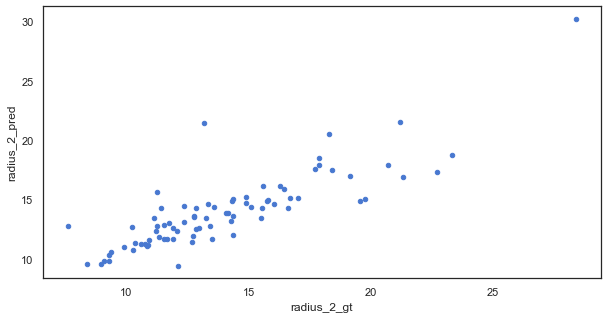

In [474]:
ax = df_test.plot.scatter(x='radius_2_gt', y='radius_2_pred', figsize=(10, 5))


In [475]:
df_test['radius_2_pred'].describe()


count    80.000000
mean     14.061971
std       3.218928
min       9.433234
25%      11.841356
50%      13.595307
75%      15.088645
max      30.219260
Name: radius_2_pred, dtype: float64

In [476]:
# Density Plot and Histogram of all arrival delays
# https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

def plot_density(df_test):
    sns.distplot(df_test['radius_2_gt'], 
                 hist=False, 
                 kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4},
                 label='radius_2_gt',
                )

    sns.distplot(df_test['radius_2_pred'], 
                 hist=False, 
                 kde=True, 
                 color = 'darkorange', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4},
                 label='radius_2_pred',
                )

    # Plot formatting
    plt.legend(prop={'size': 16},)
    plt.title('Density Plot of radius_2')
    plt.xlabel('radius_2')
    plt.ylabel('Density')
    

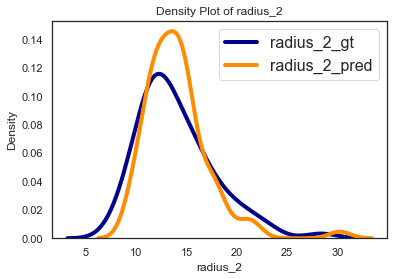

In [477]:
plot_density(df_test)


In [478]:
ks_2samp(df_test['radius_2_pred'], df_test['radius_2_gt'])


KstestResult(statistic=0.1125, pvalue=0.6953371976633547)

If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.


The null-hypothesis for the KT test is that the distributions are the same. 
Thus, the lower your p value the greater the statistical evidence you have to reject the null hypothesis and conclude the distributions are different. 
The test only really lets you speak of your confidence that the distributions are different, not the same, since the test is designed to find alpha, the probability of Type I error.

https://stackoverflow.com/questions/39132469/how-to-interpret-scipy-stats-kstest-and-ks-2samp-to-evaluate-fit-of-data-t


## Nonlinear regression


In [479]:
lgb = lgbm.LGBMRegressor()
lgb.fit(X_train_scaled, y_train)
y_pred = lgb.predict(X_test_scaled)

report_performance(y_test, y_pred)


mae: 1.59
mse: 5.02
rmse: 2.24
msle: 0.02
rmsle: 0.14


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


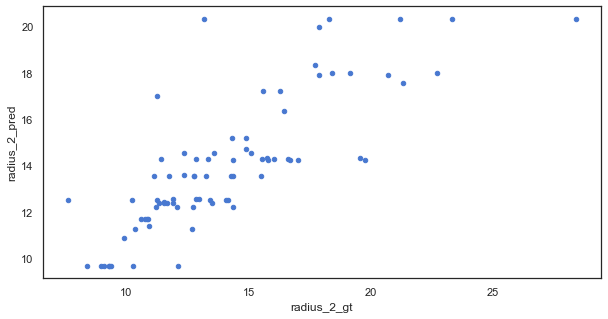

In [480]:
df_test = X_test
df_test['radius_2_gt'] = y_test.values.ravel()
df_test['radius_2_pred'] = y_pred.ravel()

ax = df_test.plot.scatter(x='radius_2_gt', y='radius_2_pred', figsize=(10, 5))


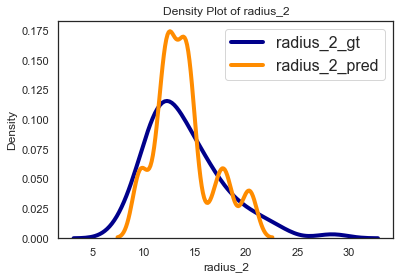

In [481]:
plot_density(df_test)
    

In [482]:
ks_2samp(df_test['radius_2_pred'], df_test['radius_2_gt'])


KstestResult(statistic=0.175, pvalue=0.17297955585145844)

**Summary**

It shows that the linear regression model outperforms the linear regression model.




## Cross-Entropy for Machine Learning

### Cross-entropy

**Cross-entropy** is commonly used in machine learning as a loss function.

Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events.

It is closely related to but is different from **KL divergence** that calculates the **relative entropy** between two probability distributions, whereas cross-entropy can be thought to calculate the **total entropy** between the distributions.


**Information** quantifies the number of bits required to encode and transmit an event. 
Lower probability events have more information, higher probability events have less information.

**Entropy** is the number of bits required to transmit a randomly selected event from a probability distribution. 

- **A skewed distribution has a low entropy, whereas a distribution where events have equal probability has a larger entropy.**

Low probability events are more surprising therefore have a larger amount of information. 
Whereas probability distributions where the events are equally likely are more surprising and have larger entropy.

- **Skewed Probability Distribution (unsurprising): Low entropy.**
- **Balanced Probability Distribution (surprising): High entropy.**


**Entropy** can be calculated for a random variable with a set of x in X discrete states discrete states and their probability P(x) as follows:

$$H(X) = – \sum_{x \in X} P(x) * \log (P(x))$$


**Cross-entropy** builds upon the idea of entropy from information theory and calculates the number of bits required to represent or transmit an average event from one distribution compared to another distribution.

**The intuition for this definition comes if we consider a target or underlying probability distribution P and an approximation of the target distribution Q, then the cross-entropy of Q from P is the number of additional bits to represent an event using Q instead of P.**

Cross-entropy can be calculated using the probabilities of the events from P and Q, as follows:

$$H(P, Q) = – \sum_{x \in X} P(x) * \log (Q(x))$$


Where P(x) is the probability of the event x in P, Q(x) is the probability of event x in Q and log is the base-2 logarithm, meaning that the results are in bits. If the base-e or natural logarithm is used instead, the result will have the units called nats.


### KL divergence

**KL divergence** can be calculated as the negative sum of probability of each event in P multiples by the log of the probability of the event in Q over the probability of the event in P. Typically, log base-2 so that the result is measured in bits.

$$ KL(P || Q) = – \sum_{x \in X} P(x) * \log ( \frac{Q(x)}{P(x)})$$


- **Cross-Entropy**: 

Average number of total bits to represent an event from Q instead of P.

- **Relative Entropy (KL Divergence)**: 

Average number of extra bits to represent an event from Q instead of P.

### Cross-Entropy as a Loss Function

Cross-entropy is widely used as a loss function when optimizing classification models.

Two examples that you may encounter include the logistic regression algorithm (a linear classification algorithm), and artificial neural networks that can be used for classification tasks.



Each example has a known class label with a probability of 1.0, and a probability of 0.0 for all other labels. A model can estimate the probability of an example belonging to each class label. Cross-entropy can then be used to calculate the difference between the two probability distributions.

As such, we can map the classification of one example onto the idea of a random variable with a probability distribution as follows:

- **Random Variable**: The example for which we require a predicted class label.
- **Events**: Each class label that could be predicted.

In the language of classification, these are the actual and the predicted probabilities, or y and yhat.

- **Expected Probability (y)**: The known probability of each class label for an example in the dataset (P).
- **Predicted Probability (yhat)**: The probability of each class label an example predicted by the model (Q).


### Cross-Entropy for regression

It comes down to the fact that cross-entropy is a concept that only makes sense when comparing two probability distributions. 
We could consider a machine learning model, e.g., neural network which outputs a mean and standard deviation for a normal distribution as its prediction. 
It would then be punished more harshly for being more confident about bad predictions. If the output is a distribution in some sense, then it makes sense to use cross-entropy cost in the context of regression.


**Reference**

https://machinelearningmastery.com/cross-entropy-for-machine-learning/


In [463]:
# calculate cross entropy
def cross_entropy(p, q):
    return -sum([p[i]*log2(q[i]) for i in range(len(p))])

# calculate the kl divergence KL(P || Q)
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

